In [2]:
import sys
sys.path.append('/u/ajagadish/ermi/categorisation/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
from collections import Counter, defaultdict
from wordcloud import WordCloud
from mycolorpy import colorlist as mcp
import math
FONTSIZE=20
SYS_PATH = '/u/ajagadish/ermi' #'/raven/u/ajagadish/vanilla-llama/'

# BERMI

# category learning 

In [58]:
def model_comparison_badham2017(FIGSIZE=(6,5)):
    models = ['task=badham2017_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_method=bounded_soft_sigmoid_optimizer=de_numiters=1',
              'badham2017_env=claude_generated_tasks_paramsNA_dim3_data100_tasks11518_pversion4_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_soft_sigmoid_differential_evolution',\
              'task=badham2017_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_method=bounded_soft_sigmoid_optimizer=de_numiters=1',
              'badham2017_env=dim3synthetic_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic_soft_sigmoid_differential_evolution',\
              'badham2017_env=rmc_tasks_dim3_data100_tasks11499_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=1_rmc_soft_sigmoid_differential_evolution',\
              'badham2017_llm_runs=1_iters=1_blocks=1_loss=nll',\
             ] 
             # 'badham2017_gcm_runs=1_iters=1_blocks=1_loss=nll',\
             #  'badham2017_rulex_runs=1_iters=1_blocks=1_loss=nll_exception=True',\
             #  'badham2017_rulex_runs=1_iters=1_blocks=1_loss=nll_exception=False',\
             #  'badham2017_pm_runs=1_iters=1_blocks=1_loss=nll',\
             #    ]
    nlls,fitted_betas, r2s = [], [], []
    model_accs = []
    bics = []
    NUM_TASKS = 4
    NUM_TRIALs = 96
    num_trials = NUM_TRIALs*NUM_TASKS
    # FONTSIZE = 16
    # MODELS = ['ERMI', 'RMC-MI', 'L-MI', 'PFN-MI', 'GCM', 'Rulex', 'Rule',  'PM']
    MODELS = ['BERMI', 'ERMI', 'BMI', 'MI',  'RMC', 'LLM']


    for model_name in models:
        fits =  np.load(f'{SYS_PATH}/categorisation/data/model_comparison/{model_name}.npz')
        if ('model=transformer' in model_name) or ('bounded_soft_sigmoid' in model_name):
            betas, pnlls, pr2s = fits['betas'], fits['nlls'], fits['pr2s']
            nlls_min_nlls = np.array(pnlls).squeeze()
            pr2s_min_nll = np.array(pr2s).squeeze()
            fitted_betas.append(betas)
            num_parameters = 1 
            bic = np.array(nlls_min_nlls)*2 + np.log(num_trials)*num_parameters
        elif ('gcm' in model_name) or ('pm' in model_name):
            betas, pnlls, pr2s = fits['params'], fits['lls'], fits['r2s']
            # summing the fits for the four conditions separately; hence the total number of parameters is model_parameters*NUM_TASKS
            nlls_min_nlls = np.array(pnlls).squeeze().sum(1)
            pr2s_min_nll = np.array(pr2s).squeeze().mean(1)
            num_parameters = 5*NUM_TASKS if ('gcm' in model_name) else 11*NUM_TASKS
            fitted_betas.append(betas.squeeze()[..., 1].mean(1))
        elif 'llm' in model_name:
            betas, pnlls, pr2s = fits['params'], fits['lls'], fits['r2s']
            # summing the fits for the four conditions separately; hence the total number of parameters is model_parameters*NUM_TASKS
            nlls_min_nlls = np.array(pnlls).squeeze().sum(1)
            pr2s_min_nll = np.array(pr2s).squeeze().mean(1)
            num_parameters = 1*NUM_TASKS 
            fitted_betas.append(betas.squeeze().mean(1))
        elif ('rulex' in model_name):
            betas, pnlls, pr2s = fits['params'], fits['lls'], fits['r2s']
            nlls_min_nlls = np.array(pnlls).squeeze().sum(1)
            pr2s_min_nll = np.array(pr2s).squeeze().mean(1)
            num_parameters = 2*NUM_TASKS
        elif ('bounded_soft_sigmoid' in model_name):
            betas, pnlls, pr2s = fits['betas'], fits['nlls'], fits['pr2s']
            nlls_min_nlls = np.array(pnlls).squeeze()
            pr2s_min_nll = np.array(pr2s).squeeze()
            fitted_betas.append(betas)
            num_parameters = 2
            bic = np.array(nlls_min_nlls)*2 + np.log(num_trials)*num_parameters
            
        bic = np.array(nlls_min_nlls)*2 + np.log(num_trials)*num_parameters
        nlls.append(nlls_min_nlls)
        r2s.append(pr2s_min_nll)
        bics.append(bic)

    # keep models and choose colors
    num_participants = len(nlls[0])
    MODELS = MODELS[:len(nlls)]
    # set colors depending on number of models in MODELS
    colors = ['#173b4f', '#8b9da7', '#173b4f', '#8b9da7', '#5d7684', '#2f4a5a', '#0d2c3d', '#4d6a75', '#748995', '#a2c0a9', '#c4d9c2'][:len(nlls)]

    # compare mean BICS across models in a bar plot
    f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    bar_positions = np.arange(len(bics))*1.5
    ax.bar(bar_positions, np.array(bics).sum(1), color=colors, width=1.)
    ax.axhline(y=-np.log(0.5)*num_trials*2*num_participants, color='r', linestyle='--', lw=3) # add chance level line for 616 trials with binary choices
    ax.set_xlabel('Models', fontsize=FONTSIZE)
    ax.set_ylabel('BIC', fontsize=FONTSIZE)
    ax.set_xticks(bar_positions)  # Set x-tick positions to bar_positions
    ax.set_xticklabels(MODELS, fontsize=FONTSIZE-6)  # Assign category names to x-tick labels
    ax.set_title(f'Model comparison for Badham et al. (2017)', fontsize=FONTSIZE)
    # plt.xticks(fontsize=FONTSIZE-2)
    plt.yticks(fontsize=FONTSIZE-2)
    # plt.ylim(min(np.array(bics).sum(1))-100, max(np.array(bics).sum(1))+100)
    sns.despine()
    f.tight_layout()
    plt.show()

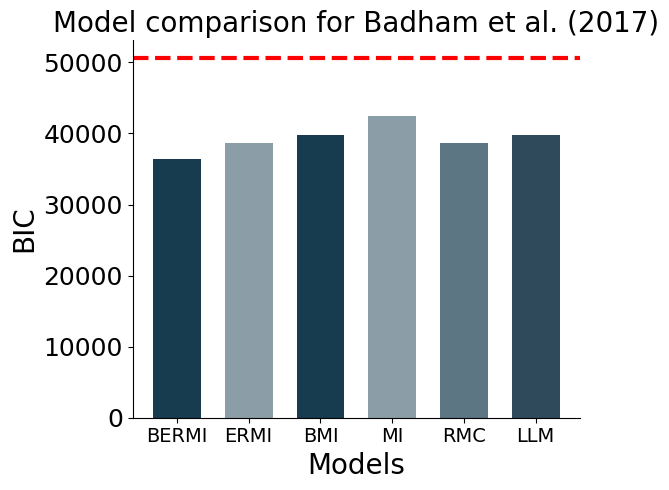

In [59]:
model_comparison_badham2017()

In [60]:
def model_comparison_devraj2022(FIGSIZE=(6,5)):
    models = ['task=devraj2022_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_method=bounded_soft_sigmoid_optimizer=de_numiters=1',\
              'devraj2022_env=claude_generated_tasks_paramsNA_dim6_data500_tasks12910_pversion5_stage2_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=1_soft_sigmoid_differential_evolution', \
            'task=devraj2022_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_method=bounded_soft_sigmoid_optimizer=de_numiters=1',\
              'devraj2022_env=dim6synthetic_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=2_synthetic_soft_sigmoid_differential_evolution',\
              'devraj2022_llm_runs=1_iters=1_blocks=1_loss=nll', \
         #      'devraj2022_gcm_runs=1_iters=1_blocks=1_loss=nll',\
         #      'devraj2022_pm_runs=1_iters=1_blocks=1_loss=nll',\
         #      'devraj2022_rulex_runs=1_iters=1_blocks=1_loss=nll_exception=True', \
         #      'devraj2022_rulex_runs=1_iters=1_blocks=1_loss=nll_exception=False', 
         ]
    nlls,fitted_betas, r2s = [], [], []
    model_accs = []
    bics = []
    NUM_TASKS = 1
    NUM_TRIALs = 616
    num_trials = NUM_TRIALs*NUM_TASKS
    # FONTSIZE = 16
    MODELS = ['BERMI', 'ERMI', 'BMI', 'MI', 'LLM']

    for model_name in models:
        fits =  np.load(f'{SYS_PATH}/categorisation/data/model_comparison/{model_name}.npz')
        if ('model=transformer' in model_name) or ('bounded_soft_sigmoid' in model_name):
            betas, pnlls, pr2s = fits['betas'], fits['nlls'], fits['pr2s']
            nlls_min_nlls = np.array(pnlls).squeeze()
            pr2s_min_nll = np.array(pr2s).squeeze()
            fitted_betas.append(betas)
            num_parameters = 1 
            bic = np.array(nlls_min_nlls)*2 + np.log(num_trials)*num_parameters
        elif ('gcm' in model_name) or ('pm' in model_name):
            betas, pnlls, pr2s = fits['params'], fits['lls'], fits['r2s']
            # summing the fits for the four conditions separately; hence the total number of parameters is model_parameters*NUM_TASKS
            nlls_min_nlls = np.array(pnlls).squeeze()
            pr2s_min_nll = np.array(pr2s).squeeze()
            num_parameters = 8*NUM_TASKS
            fitted_betas.append(betas.squeeze()[:, 1])
        elif 'llm' in model_name:
            betas, pnlls, pr2s = fits['params'], fits['lls'], fits['r2s']
            # summing the fits for the four conditions separately; hence the total number of parameters is model_parameters*NUM_TASKS
            nlls_min_nlls = np.array(pnlls).squeeze()
            pr2s_min_nll = np.array(pr2s).squeeze()
            num_parameters = 1*NUM_TASKS 
            fitted_betas.append(betas.squeeze())
        elif ('rulex' in model_name):
            betas, pnlls, pr2s = fits['params'], fits['lls'], fits['r2s']
            nlls_min_nlls = np.array(pnlls).squeeze()
            pr2s_min_nll = np.array(pr2s).squeeze()
            num_parameters = 2*NUM_TASKS
        elif ('bounded_soft_sigmoid' in model_name):
            betas, pnlls, pr2s = fits['betas'], fits['nlls'], fits['pr2s']
            nlls_min_nlls = np.array(pnlls).squeeze()
            pr2s_min_nll = np.array(pr2s).squeeze()
            fitted_betas.append(betas)
            num_parameters = 2
            bic = np.array(nlls_min_nlls)*2 + np.log(num_trials)*num_parameters

        bic = np.array(nlls_min_nlls)*2 + np.log(num_trials)*num_parameters
        nlls.append(nlls_min_nlls)
        r2s.append(pr2s_min_nll)
        bics.append(bic)

    # keep models and choose colors
    num_participants = len(nlls[0])
    MODELS = MODELS[:len(nlls)]
    # set colors depending on number of models in MODELS
    colors = ['#173b4f', '#8b9da7', '#5d7684', '#2f4a5a', '#0d2c3d', '#4d6a75', '#748995', '#a2c0a9', '#c4d9c2'][:len(nlls)]


    # compare mean BICS across models in a bar plot
    f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    bar_positions = np.arange(len(bics))*1.5
    ax.bar(bar_positions, np.array(bics).sum(1), color=colors, width=1.)
    # print bics for models and their names
    for i, bic in enumerate(bics):
        print(f'{MODELS[i]}: {bic.sum()}')
    # add chance level line for 616 trials with binary choices
    ax.axhline(y=-np.log(0.5)*num_trials*2*num_participants, color='r', linestyle='--', lw=3)
    ax.set_xlabel('Models', fontsize=FONTSIZE)
    ax.set_ylabel('BIC', fontsize=FONTSIZE)
    ax.set_xticks(bar_positions)  # Set x-tick positions to bar_positions
    ax.set_xticklabels(MODELS, fontsize=FONTSIZE-6)  # Assign category names to x-tick labels
    # ax.set_title(f'Model comparison for Badham et al. (2017)', fontsize=FONTSIZE)
    # plt.xticks(fontsize=FONTSIZE-2)
    # set y lim
    ax.set_ylim([35000, 53000])
    plt.yticks(fontsize=FONTSIZE-2)
    sns.despine()
    f.tight_layout()
    plt.show()

BERMI: 37894.18217132763
ERMI: 41207.200225999215
BMI: 40828.09330414013
MI: 47617.08311475591
LLM: 42401.42514171214


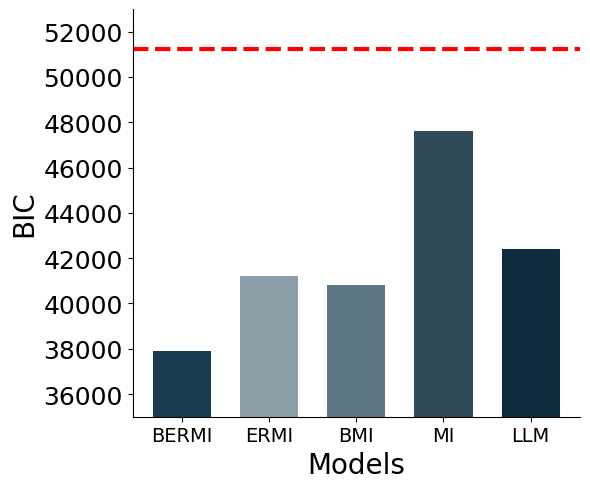

In [61]:
model_comparison_devraj2022()

# decision making

### Experiment 1: Ranking

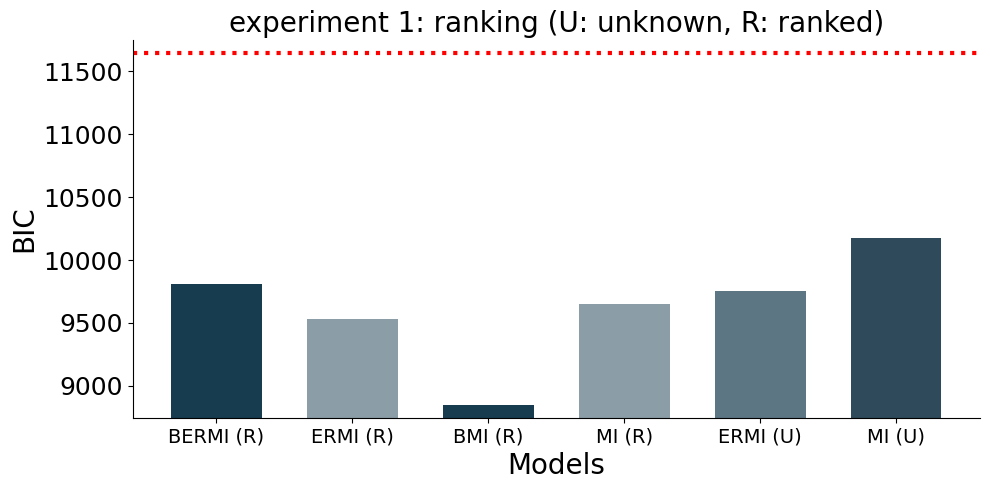

In [16]:
experiment_id=1
data = pd.read_csv(f'/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp{experiment_id}.csv')
num_participants = data.participant.nunique()
num_trials = 300 

# load model fits
## old 
# results_mi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
# results_ermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
## new
results_mi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')
results_ermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')

## old
# results_mi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=rank_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
# results_ermi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=rank_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
## new
results_mi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=rank_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')
results_ermi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=rank_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')


## dropout
# results_bmi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=rank_loss=nll_paired=True_method=bounded_soft_sigmoid_optimizer=de_numiters=1.npz')
# results_bermi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=rank_loss=nll_paired=True_method=bounded_soft_sigmoid_optimizer=de_numiters=1.npz')

## l2 regularisation
results_bmi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=rank_loss=nll_paired=True_method=bounded_optimizer=grid_search_numiters=5.npz')
results_bermi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=rank_loss=nll_paired=True_method=bounded_optimizer=grid_search_numiters=5.npz')


logprobs_bmi = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id}_bmli.pth')[0]
logprobs_baselines = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id}_fitted.pth')[0]
logprobs_bmi = torch.cat([logprobs_baselines[:, [0]], logprobs_bmi], dim=-1)
best_logprobs, best_index = torch.max(logprobs_bmi, dim=-1)


# compute BIC
ermi_paired_ranked_bic = (2*results_ermi_paired_ranked['nlls'] + 1*np.log(num_trials)).sum()
mi_paired_ranked_bic = (2*results_mi_paired_ranked['nlls']+ 1*np.log(num_trials)).sum() 

ermi_paired_unknown_bic = (2*results_ermi_paired['nlls'] + 1*np.log(num_trials)).sum()
mi_paired_unknown_bic = (2*results_mi_paired['nlls']+ 1*np.log(num_trials)).sum() 

bermi_paired_ranked_bic = (2*results_bermi_paired_ranked['nlls'] + 2*np.log(num_trials)).sum()
bmi_paired_ranked_bic = (2*results_bmi_paired_ranked['nlls'] + 2*np.log(num_trials)).sum()

# ermi_bic = (2*results_ermi['nlls']+ 1*np.log(num_trials)).sum() 
# mi_bic = (2*results_mi['nlls']+ 1*np.log(num_trials)).sum() 


rnn_mi_bic = (-2*logprobs_bmi[:, 1] + 1*np.log(num_trials)).sum() 
rnn_bmi_bic = (-2*best_logprobs + 2*np.log(num_trials)).sum()
random_bic = -2*np.log(0.5)*num_trials*num_participants

# pool results
# bics = [ermi_paired_unknown_bic, mi_paired_unknown_bic, bermi_paired_ranked_bic, ermi_paired_ranked_bic, bmi_paired_ranked_bic, mi_paired_ranked_bic, rnn_mi_bic, rnn_bmi_bic, random_bic]
# model_names = ['ERMI_L (Unkown)', 'MI_L (U)', 'BERMI_L (Ranked)', 'ERMI_L (Ranked)', 'BMI_L (R)', 'MI_L (R)', 'MI_L_RNN', 'BMI_L_RNN', 'random']

bics = [bermi_paired_ranked_bic, ermi_paired_ranked_bic, bmi_paired_ranked_bic, mi_paired_ranked_bic,ermi_paired_unknown_bic, mi_paired_unknown_bic]# rnn_mi_bic, rnn_bmi_bic]
MODELS = ['BERMI (R)', 'ERMI (R)', 'BMI (R)', 'MI (R)', 'ERMI (U)', 'MI (U)']# 'MI_L_RNN', 'BMI_L_RNN']

# bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic]#, random_bic]
# model_names = ['ERMI_BMI', 'MI_BMI',  'RNN_BMI', 'RNN_MI']#, 'random']

# bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic, ermi_bic, mi_bic,]#, random_bic]
# model_names = ['ERMI_L', 'MI_L',  'RNN_BMI_L', 'RNN_MI_L', 'ERMI', 'MI']#, 'random']


# plot bar plot comparing the two bics
# plt.figure(figsize=(10, len(model_names)))
# plt.bar(MODELS, bics)
# plt.hlines(xmin=-0.5, xmax=len(model_names)-0.5, y=random_bic, color='red')
# plt.ylim(min(bics)-100, random_bic+100)
# plt.ylabel('BIC')
# plt.title('experiment 1: ranking (U: unknown, R: ranked)')
# sns.despine()



# set colors depending on number of models in MODELS
colors = ['#173b4f', '#8b9da7', '#173b4f', '#8b9da7', '#5d7684', '#2f4a5a', '#0d2c3d', '#4d6a75', '#748995', '#a2c0a9', '#c4d9c2'][:len(bics)]
FIGSIZE = (10,5)
# compare mean BICS across models in a bar plot
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
bar_positions = np.arange(len(bics))*1.5
ax.bar(bar_positions, np.array(bics), color=colors, width=1.)
# add chance level line for 616 trials with binary choices
# ax.axhline(y=-np.log(0.5)*num_trials*2, color='k', linestyle='--', lw=3)
ax.set_xlabel('Models', fontsize=FONTSIZE)
ax.set_ylabel('BIC', fontsize=FONTSIZE)
ax.set_xticks(bar_positions)  # Set x-tick positions to bar_positions
ax.set_xticklabels(MODELS, fontsize=FONTSIZE-6)  # Assign category names to x-tick labels
ax.set_title(f'experiment 1: ranking (U: unknown, R: ranked)', fontsize=FONTSIZE)
ax.axhline(y=random_bic, color='red', linestyle='dotted', lw=3)
# plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.ylim(min(bics)-100, random_bic+100)
sns.despine()
f.tight_layout()
plt.show()

### Experiment 2: Direction

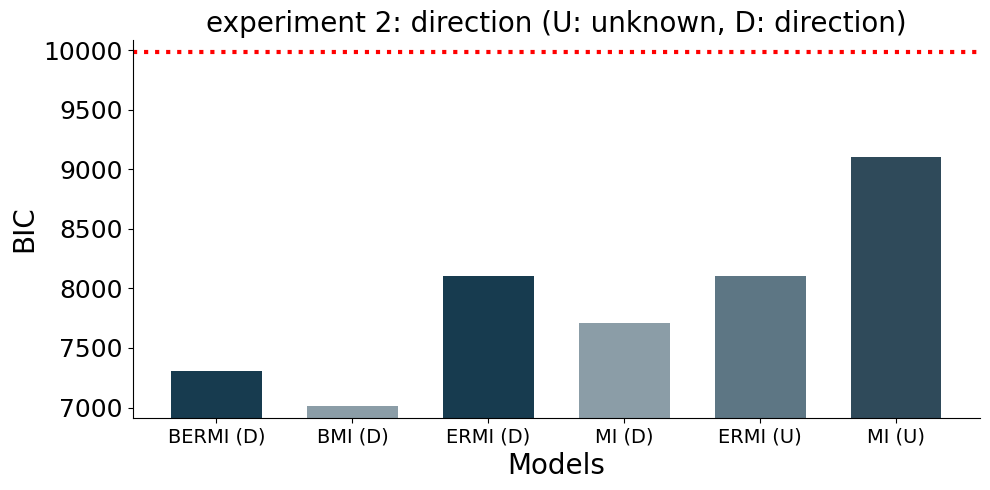

In [57]:
experiment_id=2
data = pd.read_csv(f'/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp{experiment_id}.csv')
num_participants = data.participant.nunique()
num_trials = 300 

# load model fits
## old
# results_mi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
# results_ermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
# results_mi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=direction_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
# results_ermi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=direction_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
## new
results_mi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=direction_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')
results_ermi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=direction_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')

results_mi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')
results_ermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')

# dropout
# results_bmi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=direction_loss=nll_paired=True_method=bounded_soft_sigmoid_optimizer=de_numiters=1.npz')
# results_bermi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=direction_loss=nll_paired=True_method=bounded_soft_sigmoid_optimizer=de_numiters=1.npz')

# l2 regularized
results_bmi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=direction_loss=nll_paired=True_method=bounded_optimizer=grid_search_numiters=5.npz')
results_bermi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=direction_loss=nll_paired=True_method=bounded_optimizer=grid_search_numiters=5.npz')


# results_mi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=synthetic_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic_pairedFalse_soft_sigmoid_differential_evolution.npz')
# results_ermi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_pairedFalse_soft_sigmoid_de.npz')
logprobs_bmi = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id}_bmli.pth')[0]
logprobs_baselines = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id}_fitted.pth')[0]
logprobs_bmi = torch.cat([logprobs_baselines[:, [0]], logprobs_bmi], dim=-1)
best_logprobs, best_index = torch.max(logprobs_bmi, dim=-1)


# compute BIC
ermi_paired_direction_bic = (2*results_ermi_paired_direction['nlls'] + 1*np.log(num_trials)).sum()
mi_paired_direction_bic = (2*results_mi_paired_direction['nlls']+ 1*np.log(num_trials)).sum() 

ermi_paired_unknown_bic = (2*results_ermi_paired['nlls'] + 1*np.log(num_trials)).sum()
mi_paired_unknown_bic = (2*results_mi_paired['nlls']+ 1*np.log(num_trials)).sum() 

bermi_paired_direction_bic = (2*results_bermi_paired_direction['nlls'] + 2*np.log(num_trials)).sum()
bmi_paired_direction_bic = (2*results_bmi_paired_direction['nlls']+ 2*np.log(num_trials)).sum() 

# ermi_bic = (2*results_ermi['nlls']+ 1*np.log(num_trials)).sum() 
# mi_bic = (2*results_mi['nlls']+ 1*np.log(num_trials)).sum() 


rnn_mi_bic = (-2*logprobs_bmi[:, 1] + 1*np.log(num_trials)).sum() 
rnn_bmi_bic = (-2*best_logprobs + 2*np.log(num_trials)).sum()
random_bic = -2*np.log(0.5)*num_trials*num_participants

# pool results
# bics = [ermi_paired_unknown_bic, mi_paired_unknown_bic, ermi_paired_direction_bic, mi_paired_direction_bic, rnn_mi_bic, rnn_bmi_bic, random_bic]
# model_names = ['ERMI_L (Unkown)', 'MI_L (U)', 'ERMI_L (Direction)', 'MI_L (D)', 'MI_L_RNN', 'BMI_L_RNN', 'random']

bics = [bermi_paired_direction_bic, bmi_paired_direction_bic, ermi_paired_direction_bic, mi_paired_direction_bic, ermi_paired_unknown_bic, mi_paired_unknown_bic]#, rnn_mi_bic, rnn_bmi_bic]# random_bic]
MODELS = ['BERMI (D)', 'BMI (D)', 'ERMI (D)', 'MI (D)', 'ERMI (U)', 'MI (U)']#, 'MI_L_RNN', 'BMI_L_RNN']#, 'random']


# bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic]#, random_bic]
# model_names = ['ERMI_BMI', 'MI_BMI',  'RNN_BMI', 'RNN_MI']#, 'random']

# bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic, ermi_bic, mi_bic,]#, random_bic]
# model_names = ['ERMI_L', 'MI_L',  'RNN_BMI_L', 'RNN_MI_L', 'ERMI', 'MI']#, 'random']


# # plot bar plot comparing the two bics
# plt.figure(figsize=(10, len(model_names)))
# plt.bar(MODELS, bics)
# plt.hlines(xmin=-0.5, xmax=len(model_names)-0.5, y=random_bic, color='red')
# plt.ylim(min(bics)-100, random_bic+100)
# plt.ylabel('BIC')
# plt.title('experiment 2: direction (U: unknown, D: direction)')
# sns.despine()



# set colors depending on number of models in MODELS
colors = ['#173b4f', '#8b9da7', '#173b4f', '#8b9da7', '#5d7684', '#2f4a5a', '#0d2c3d', '#4d6a75', '#748995', '#a2c0a9', '#c4d9c2'][:len(bics)]
FIGSIZE = (10,5)
# compare mean BICS across models in a bar plot
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
bar_positions = np.arange(len(bics))*1.5
ax.bar(bar_positions, np.array(bics), color=colors, width=1.)
# add chance level line for 616 trials with binary choices
# ax.axhline(y=-np.log(0.5)*num_trials*2, color='k', linestyle='--', lw=3)
ax.set_xlabel('Models', fontsize=FONTSIZE)
ax.set_ylabel('BIC', fontsize=FONTSIZE)
ax.set_xticks(bar_positions)  # Set x-tick positions to bar_positions
ax.set_xticklabels(MODELS, fontsize=FONTSIZE-6)  # Assign category names to x-tick labels
ax.set_title(f'experiment 2: direction (U: unknown, D: direction)', fontsize=FONTSIZE)
ax.axhline(y=random_bic, color='red', linestyle='dotted', lw=3)
# plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.ylim(min(bics)-100, random_bic+100)
sns.despine()
f.tight_layout()
plt.show()

### Experiment 3: Unknown (two dimensional features)

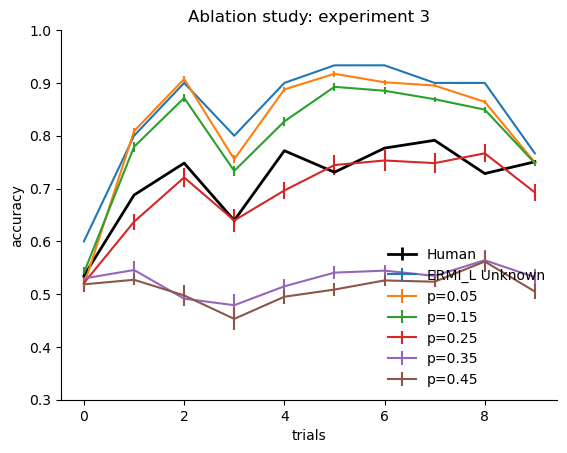

In [33]:
experiment_id=3
data = pd.read_csv(f'/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp{experiment_id}.csv')
num_tasks = data.task.max()+1
policy='greedy'
data = pd.read_csv(f'/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp{experiment_id}.csv')
# results_ermi = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
# results_mi = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
# results_mi_paired_unknown = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_policy=greedy.npz')
results_ermi_paired_unknown = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_policy=greedy.npz')

plt.errorbar(x=np.arange(10), y=(results_ermi_paired_unknown['per_trial_human_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_unknown['human_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), c='k', lw=2, label='Human')
plt.errorbar(x=np.arange(10), y=(results_ermi_paired_unknown['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_unknown['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI_L Unknown')
for ablation_level in np.arange(5, 50, 10):
    results_ermi_paired_unknown_ablated = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_ablation/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_policy=greedy_percentneurons={ablation_level}_layer=all_layers.npz')
    plt.errorbar(x=np.arange(10), y=(results_ermi_paired_unknown_ablated['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_unknown_ablated['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label=f'p={float(ablation_level/100)}')

plt.ylabel('accuracy')
plt.xlabel('trials')
plt.ylim(0.3, 1.) # set y axis limit between 0.5 and 1.
sns.despine()
plt.legend(loc='lower right')
plt.title(f"Ablation study: experiment {experiment_id}")
plt.legend(frameon=False)
plt.show()

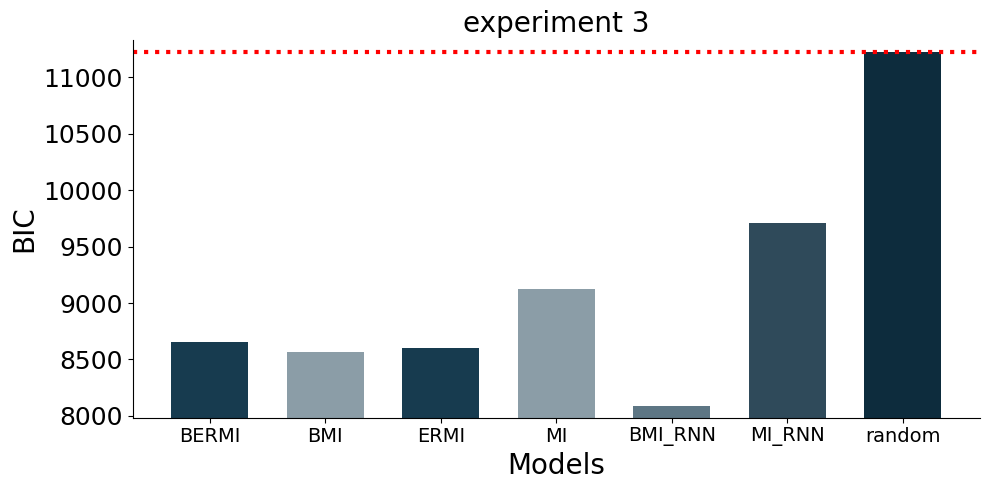

In [19]:
experiment_id=3
data = pd.read_csv(f'/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp{experiment_id}.csv')
num_participants = data.participant.nunique()
num_trials = 300 

# load model fits
results_ermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')
results_bermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_method=bounded_optimizer=grid_search_numiters=5.npz')

results_mi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')
results_bmi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_method=bounded_optimizer=grid_search_numiters=5.npz')

# old
# results_bermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_method=bounded_soft_sigmoid_optimizer=de_numiters=5.npz')
# results_bmi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_method=bounded_soft_sigmoid_optimizer=de_numiters=1.npz')
# results_mi = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=False_method=soft_sigmoid_optimizer=de.npz')
# results_ermi = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=False_method=soft_sigmoid_optimizer=de.npz')

logprobs_bmi = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id+1}_bmli.pth')[0]
logprobs_baselines = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id+1}_fitted.pth')[0]
logprobs_bmi = torch.cat([logprobs_baselines[:, [0]], logprobs_bmi], dim=-1)
best_logprobs, best_index = torch.max(logprobs_bmi, dim=-1)


# compute BIC
bermi_paired_bic = (2*results_bermi_paired['nlls'] + 2*np.log(num_trials)).sum()
bmi_paired_bic = (2*results_bmi_paired['nlls'] + 2*np.log(num_trials)).sum()

ermi_paired_bic = (2*results_ermi_paired['nlls'] + 1*np.log(num_trials)).sum()
mi_paired_bic = (2*results_mi_paired['nlls']+ 1*np.log(num_trials)).sum() 

# ermi_bic = (2*results_ermi['nlls']+ 1*np.log(num_trials)).sum() 
# mi_bic = (2*results_mi['nlls']+ 1*np.log(num_trials)).sum() 

rnn_mi_bic = (-2*logprobs_bmi[:, 1]).sum() #+ 1*np.log(num_trials)).sum() 
rnn_bmi_bic = (-2*best_logprobs + 2*np.log(num_trials)).sum()
random_bic = -2*np.log(0.5)*num_trials*num_participants

# pool results
# bics = [ermi_bic, mi_bic, ermi_paired_bic, mi_paired_bic, rnn_mi_bic, rnn_bmi_bic, random_bic]
# model_names = ['ERMI', 'MI', 'ERMI_L', 'MI_L', 'MI_L_RNN', 'BMI_L_RNN', 'random']

bics = [bermi_paired_bic, bmi_paired_bic, ermi_paired_bic, mi_paired_bic, rnn_bmi_bic, rnn_mi_bic, random_bic]
MODELS = ['BERMI', 'BMI', 'ERMI', 'MI', 'BMI_RNN', 'MI_RNN', 'random']

# plot bar plot comparing the two bics
# plt.figure(figsize=(10,len(bics)))
# plt.bar(model_names, bics)
# plt.ylim(min(bics)-100, max(bics)+100)
# plt.ylabel('BIC')
# sns.despine()


# set colors depending on number of models in MODELS
colors = ['#173b4f', '#8b9da7', '#173b4f', '#8b9da7', '#5d7684', '#2f4a5a', '#0d2c3d', '#4d6a75', '#748995', '#a2c0a9', '#c4d9c2'][:len(bics)]
FIGSIZE = (10,5)
# compare mean BICS across models in a bar plot
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
bar_positions = np.arange(len(bics))*1.5
ax.bar(bar_positions, np.array(bics), color=colors, width=1.)
# add chance level line for 616 trials with binary choices
# ax.axhline(y=-np.log(0.5)*num_trials*2, color='k', linestyle='--', lw=3)
ax.set_xlabel('Models', fontsize=FONTSIZE)
ax.set_ylabel('BIC', fontsize=FONTSIZE)
ax.set_xticks(bar_positions)  # Set x-tick positions to bar_positions
ax.set_xticklabels(MODELS, fontsize=FONTSIZE-6)  # Assign category names to x-tick labels
ax.set_title(f'experiment 3', fontsize=FONTSIZE)
ax.axhline(y=random_bic, color='red', linestyle='dotted', lw=3)
# plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.ylim(min(bics)-100, random_bic+100)
sns.despine()
f.tight_layout()
plt.show()

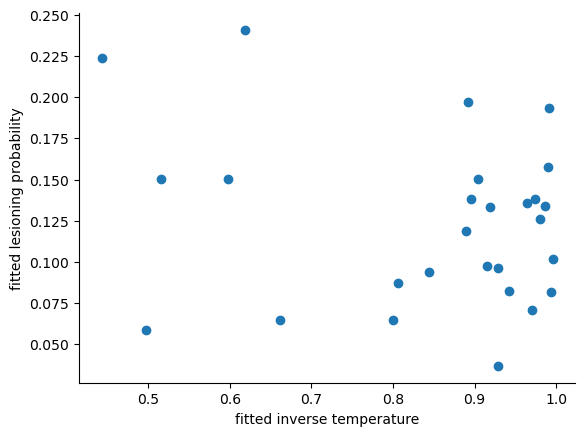

In [4]:
plt.scatter(results_bermi_paired['betas'][:,1], results_bermi_paired['betas'][:,0])
plt.xlabel('fitted inverse temperature')
plt.ylabel('fitted lesioning probability')
sns.despine()

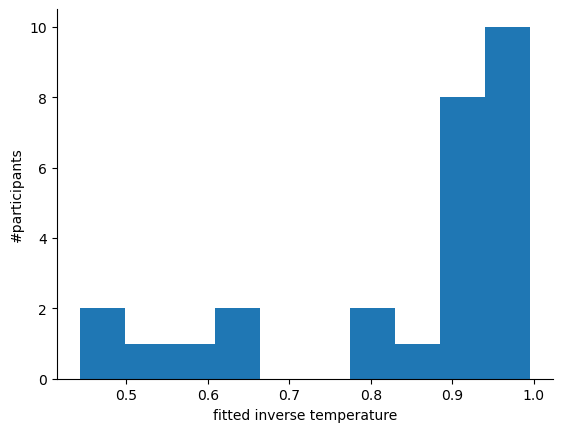

In [5]:
plt.hist(results_bermi_paired['betas'][:,1])
plt.ylabel('#participants')
plt.xlabel('fitted inverse temperature')
sns.despine()

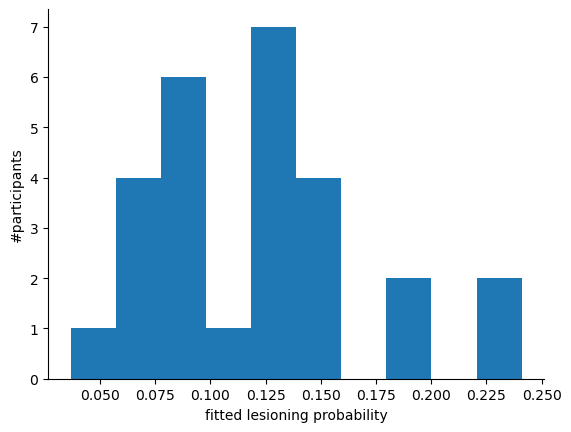

In [6]:
plt.hist(results_bermi_paired['betas'][:,0])
plt.ylabel('#participants')
plt.xlabel('fitted lesioning probability')
sns.despine()

### Experiment 4: Unknown (4 dims)

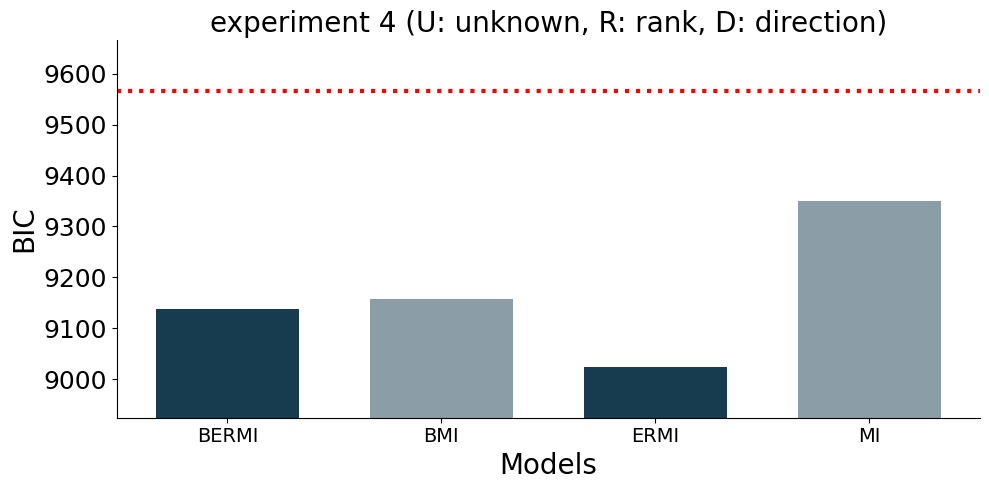

In [9]:
experiment_id= 4
data = pd.read_csv(f'/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp{experiment_id}.csv')
num_participants = data.participant.nunique()
num_trials = 300 

# load model fits
# results_mi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=direction_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')
# results_ermi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=direction_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')
# results_mi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=rank_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')
# results_ermi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=rank_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')
results_mi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')
results_ermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_method=unbounded_optimizer=grid_search_numiters=5.npz')


# l2 regularized
# results_bmi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=direction_loss=nll_paired=True_method=bounded_optimizer=grid_search_numiters=5.npz')
# results_bermi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=direction_loss=nll_paired=True_method=bounded_optimizer=grid_search_numiters=5.npz')
# results_bmi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=rank_loss=nll_paired=True_method=bounded_optimizer=grid_search_numiters=5.npz')
# results_bermi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=rank_loss=nll_paired=True_method=bounded_optimizer=grid_search_numiters=5.npz')
results_bermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_method=bounded_optimizer=grid_search_numiters=5.npz')
results_bmi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_method=bounded_optimizer=grid_search_numiters=5.npz')


# results_mi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=synthetic_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic_pairedFalse_soft_sigmoid_differential_evolution.npz')
# results_ermi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_pairedFalse_soft_sigmoid_de.npz')
logprobs_bmi = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id}_bmli.pth')[0]
logprobs_baselines = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id}_fitted.pth')[0]
logprobs_bmi = torch.cat([logprobs_baselines[:, [0]], logprobs_bmi], dim=-1)
best_logprobs, best_index = torch.max(logprobs_bmi, dim=-1)


# compute BIC
# ermi_paired_direction_bic = (2*results_ermi_paired_direction['nlls'] + 1*np.log(num_trials)).sum()
# mi_paired_direction_bic = (2*results_mi_paired_direction['nlls']+ 1*np.log(num_trials)).sum() 
# bermi_paired_direction_bic = (2*results_bmi_paired_direction['nlls'] + 1*np.log(num_trials)).sum()
# bmi_paired_direction_bic = (2*results_bermi_paired_direction['nlls']+ 1*np.log(num_trials)).sum() 

# ermi_paired_ranked_bic = (2*results_ermi_paired_ranked['nlls'] + 1*np.log(num_trials)).sum()
# mi_paired_ranked_bic = (2*results_mi_paired_ranked['nlls']+ 1*np.log(num_trials)).sum() 
# bermi_paired_ranked_bic = (2*results_bermi_paired_ranked['nlls'] + 2*np.log(num_trials)).sum()
# bmi_paired_ranked_bic = (2*results_bmi_paired_ranked['nlls'] + 2*np.log(num_trials)).sum()

bermi_paired_bic = (2*results_bermi_paired['nlls'] + 2*np.log(num_trials)).sum()
bmi_paired_bic = (2*results_bmi_paired['nlls'] + 2*np.log(num_trials)).sum()
ermi_paired_bic = (2*results_ermi_paired['nlls'] + 1*np.log(num_trials)).sum()
mi_paired_bic = (2*results_mi_paired['nlls']+ 1*np.log(num_trials)).sum() 

# ermi_bic = (2*results_ermi['nlls']+ 1*np.log(num_trials)).sum() 
# mi_bic = (2*results_mi['nlls']+ 1*np.log(num_trials)).sum() 


rnn_mi_bic = (-2*logprobs_bmi[:, 1] + 1*np.log(num_trials)).sum() 
rnn_bmi_bic = (-2*best_logprobs + 2*np.log(num_trials)).sum()
random_bic = -2*np.log(0.5)*num_trials*num_participants

# pool results
# bics = [ermi_paired_unknown_bic, mi_paired_unknown_bic, ermi_paired_direction_bic, mi_paired_direction_bic, rnn_mi_bic, rnn_bmi_bic, random_bic]
# model_names = ['ERMI_L (Unkown)', 'MI_L (U)', 'ERMI_L (Direction)', 'MI_L (D)', 'MI_L_RNN', 'BMI_L_RNN', 'random']

# bics = [bermi_paired_direction_bic, bmi_paired_direction_bic, ermi_paired_direction_bic, mi_paired_direction_bic, bermi_paired_ranked_bic, ermi_paired_ranked_bic, bmi_paired_ranked_bic, mi_paired_ranked_bic, ermi_paired_bic, mi_paired_bic, bmi_paired_bic, bermi_paired_bic]#, rnn_mi_bic, rnn_bmi_bic]# random_bic]
bics = [bermi_paired_bic, bmi_paired_bic, ermi_paired_bic, mi_paired_bic]#, rnn_mi_bic, rnn_bmi_bic]# random_bic]

# MODELS = ['BERMI (D)', 'BMI (D)', 'ERMI (D)', 'MI (D)', 'ERMI (U)', 'MI (U)']#, 'MI_L_RNN', 'BMI_L_RNN']#, 'random']
MODELS = ['BERMI', 'BMI', 'ERMI', 'MI']#, 'random']

# bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic]#, random_bic]
# model_names = ['ERMI_BMI', 'MI_BMI',  'RNN_BMI', 'RNN_MI']#, 'random']

# bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic, ermi_bic, mi_bic,]#, random_bic]
# model_names = ['ERMI_L', 'MI_L',  'RNN_BMI_L', 'RNN_MI_L', 'ERMI', 'MI']#, 'random']


# # plot bar plot comparing the two bics
# plt.figure(figsize=(10, len(model_names)))
# plt.bar(MODELS, bics)
# plt.hlines(xmin=-0.5, xmax=len(model_names)-0.5, y=random_bic, color='red')
# plt.ylim(min(bics)-100, random_bic+100)
# plt.ylabel('BIC')
# plt.title('experiment 2: direction (U: unknown, D: direction)')
# sns.despine()



# set colors depending on number of models in MODELS
colors = ['#173b4f', '#8b9da7', '#173b4f', '#8b9da7', '#5d7684', '#2f4a5a', '#0d2c3d', '#4d6a75', '#748995', '#a2c0a9', '#c4d9c2'][:len(bics)]
FIGSIZE = (10,5)
# compare mean BICS across models in a bar plot
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
bar_positions = np.arange(len(bics))*1.5
ax.bar(bar_positions, np.array(bics), color=colors, width=1.)
# add chance level line for 616 trials with binary choices
# ax.axhline(y=-np.log(0.5)*num_trials*2, color='k', linestyle='--', lw=3)
ax.set_xlabel('Models', fontsize=FONTSIZE)
ax.set_ylabel('BIC', fontsize=FONTSIZE)
ax.set_xticks(bar_positions)  # Set x-tick positions to bar_positions
ax.set_xticklabels(MODELS, fontsize=FONTSIZE-6)  # Assign category names to x-tick labels
ax.set_title(f'experiment {experiment_id} (U: unknown, R: rank, D: direction)', fontsize=FONTSIZE)
ax.axhline(y=random_bic, color='red', linestyle='dotted', lw=3)
# plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.ylim(min(bics)-100, random_bic+100)
sns.despine()
f.tight_layout()
plt.show()

## Model simulation and comparision for Binz 2022

### Experiment 1: Ranking

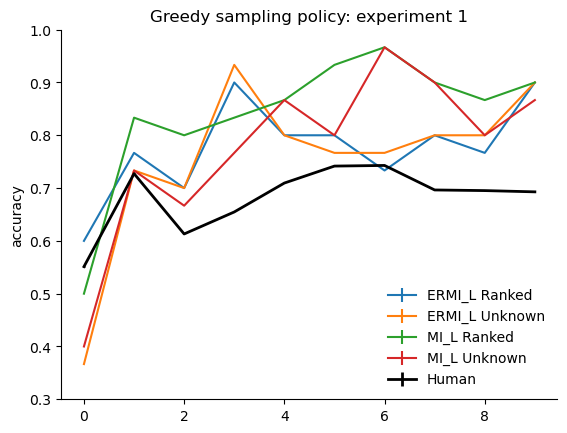

In [80]:
experiment_id=1
data = pd.read_csv(f'/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp{experiment_id}.csv')
num_tasks = data.task.max()+1
results_ermi_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment=1_source=claude_condition=rank_loss=nll_paired=False_policy=greedy.npz')
results_mi_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment=1_source=synthetic_condition=rank_loss=nll_paired=False_policy=greedy.npz')
results_ermi_unknown = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
results_mi_unknown = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
results_mi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment=1_source=synthetic_condition=rank_loss=nll_paired=True_policy=greedy.npz')
results_mi_paired_unknown = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=True_policy=greedy.npz')          
results_ermi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment=1_source=claude_condition=rank_loss=nll_paired=True_policy=greedy.npz')
results_ermi_paired_unknown = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment=1_source=claude_condition=unknown_loss=nll_paired=True_policy=greedy.npz')


plt.errorbar(x=np.arange(10), y=(results_ermi_paired_ranked['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_ranked['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI_L Ranked')
plt.errorbar(x=np.arange(10), y=(results_ermi_paired_unknown['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_unknown['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI_L Unknown')
plt.errorbar(x=np.arange(10), y=(results_mi_paired_ranked['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi_paired_ranked['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI_L Ranked')
plt.errorbar(x=np.arange(10), y=(results_mi_paired_unknown['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi_paired_unknown['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI_L Unknown')

# plt.errorbar(x=np.arange(10), y=(results_ermi_ranked['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_ranked['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI Ranked')
# plt.errorbar(x=np.arange(10), y=(results_mi_ranked['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi_ranked['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI Ranked')
# plt.errorbar(x=np.arange(10), y=(results_ermi_unknown['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_unknown['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI Unknown')
# plt.errorbar(x=np.arange(10), y=(results_mi_unknown['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi_unknown['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI Unknown')


plt.errorbar(x=np.arange(10), y=(results_mi_paired_ranked['per_trial_human_accuracy']/num_tasks).mean(0),yerr=(results_mi_paired_ranked['human_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), c='k', lw=2, label='Human')

plt.ylabel('accuracy')
plt.ylim(0.3, 1.) # set y axis limit between 0.5 and 1.
sns.despine()
plt.title(f"{policy} sampling policy: experiment {experiment_id}")
plt.legend(frameon=False)
plt.show()

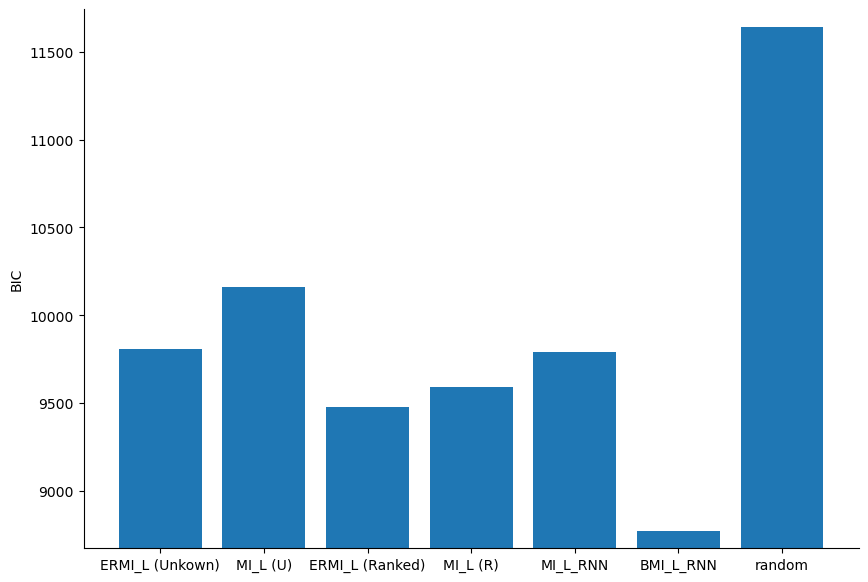

In [81]:
experiment_id=1
data = pd.read_csv(f'/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp{experiment_id}.csv')
num_participants = data.participant.nunique()
num_trials = 300 

# load model fits
results_mi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
results_ermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
results_mi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=rank_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
results_ermi_paired_ranked = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=rank_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
# results_mi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=synthetic_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic_pairedFalse_soft_sigmoid_differential_evolution.npz')
# results_ermi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_pairedFalse_soft_sigmoid_de.npz')
logprobs_bmi = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id}_bmli.pth')[0]
logprobs_baselines = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id}_fitted.pth')[0]
logprobs_bmi = torch.cat([logprobs_baselines[:, [0]], logprobs_bmi], dim=-1)
best_logprobs, best_index = torch.max(logprobs_bmi, dim=-1)


# compute BIC
ermi_paired_ranked_bic = (2*results_ermi_paired_ranked['nlls'] + 1*np.log(num_trials)).sum()
mi_paired_ranked_bic = (2*results_mi_paired_ranked['nlls']+ 1*np.log(num_trials)).sum() 
ermi_paired_unknown_bic = (2*results_ermi_paired['nlls'] + 1*np.log(num_trials)).sum()
mi_paired_unknown_bic = (2*results_mi_paired['nlls']+ 1*np.log(num_trials)).sum() 

# ermi_bic = (2*results_ermi['nlls']+ 1*np.log(num_trials)).sum() 
# mi_bic = (2*results_mi['nlls']+ 1*np.log(num_trials)).sum() 


rnn_mi_bic = (-2*logprobs_bmi[:, 1] + 1*np.log(num_trials)).sum() 
rnn_bmi_bic = (-2*best_logprobs + 2*np.log(num_trials)).sum()
random_bic = -2*np.log(0.5)*num_trials*num_participants

# pool results
bics = [ermi_paired_unknown_bic, mi_paired_unknown_bic, ermi_paired_ranked_bic, mi_paired_ranked_bic, rnn_mi_bic, rnn_bmi_bic, random_bic]
model_names = ['ERMI_L (Unkown)', 'MI_L (U)', 'ERMI_L (Ranked)', 'MI_L (R)', 'MI_L_RNN', 'BMI_L_RNN', 'random']

# bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic]#, random_bic]
# model_names = ['ERMI_BMI', 'MI_BMI',  'RNN_BMI', 'RNN_MI']#, 'random']

# bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic, ermi_bic, mi_bic,]#, random_bic]
# model_names = ['ERMI_L', 'MI_L',  'RNN_BMI_L', 'RNN_MI_L', 'ERMI', 'MI']#, 'random']


# plot bar plot comparing the two bics
plt.figure(figsize=(10, len(model_names)))
plt.bar(model_names, bics)
plt.ylim(min(bics)-100, max(bics)+100)
plt.ylabel('BIC')
sns.despine()

### Experiment 2: Direction

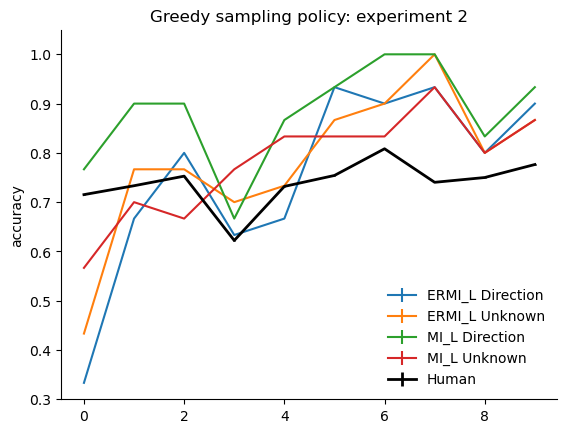

In [78]:
experiment_id=2
data = pd.read_csv(f'/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp{experiment_id}.csv')
num_tasks = data.task.max()+1
policy='Greedy'
results_ermi_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=claude_condition=direction_loss=nll_paired=False_policy=greedy.npz')
results_mi_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=synthetic_condition=direction_loss=nll_paired=False_policy=greedy.npz')
results_ermi_unknown = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
results_mi_unknown = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
results_mi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=synthetic_condition=direction_loss=nll_paired=True_policy=greedy.npz')
results_mi_paired_unknown = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_policy=greedy.npz')          
results_ermi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=claude_condition=direction_loss=nll_paired=True_policy=greedy.npz')
results_ermi_paired_unknown = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_policy=greedy.npz')


plt.errorbar(x=np.arange(10), y=(results_ermi_paired_direction['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_direction['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI_L Direction')
plt.errorbar(x=np.arange(10), y=(results_ermi_paired_unknown['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_unknown['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI_L Unknown')
plt.errorbar(x=np.arange(10), y=(results_mi_paired_direction['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi_paired_direction['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI_L Direction')
plt.errorbar(x=np.arange(10), y=(results_mi_paired_unknown['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi_paired_unknown['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI_L Unknown')

# plt.errorbar(x=np.arange(10), y=(results_ermi_direction['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_direction['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI Ranked')
# plt.errorbar(x=np.arange(10), y=(results_mi_direction['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi_direction['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI Ranked')
# plt.errorbar(x=np.arange(10), y=(results_ermi_unknown['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_unknown['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI Unknown')
# plt.errorbar(x=np.arange(10), y=(results_mi_unknown['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi_unknown['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI Unknown')


plt.errorbar(x=np.arange(10), y=(results_mi_paired_direction['per_trial_human_accuracy']/num_tasks).mean(0),yerr=(results_mi_paired_direction['human_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), c='k', lw=2, label='Human')

plt.ylabel('accuracy')
plt.ylim(0.3, 1.05) # set y axis limit between 0.5 and 1.
sns.despine()
plt.title(f"{policy} sampling policy: experiment {experiment_id}")
plt.legend(frameon=False)
plt.show()

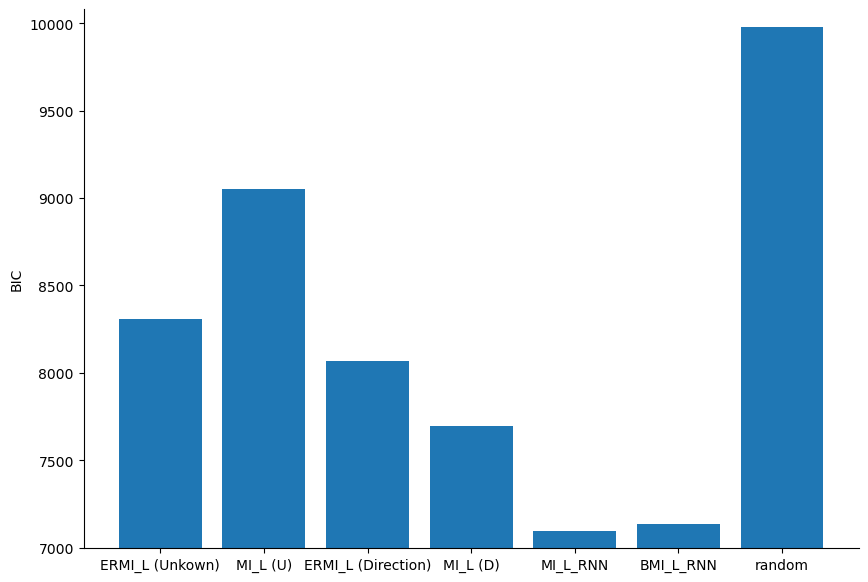

In [79]:
experiment_id=2
data = pd.read_csv(f'/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp{experiment_id}.csv')
num_participants = data.participant.nunique()
num_trials = 300 

# load model fits
results_mi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
results_ermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
results_mi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=direction_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
results_ermi_paired_direction = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=direction_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
# results_mi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=synthetic_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic_pairedFalse_soft_sigmoid_differential_evolution.npz')
# results_ermi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_pairedFalse_soft_sigmoid_de.npz')
logprobs_bmi = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id}_bmli.pth')[0]
logprobs_baselines = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id}_fitted.pth')[0]
logprobs_bmi = torch.cat([logprobs_baselines[:, [0]], logprobs_bmi], dim=-1)
best_logprobs, best_index = torch.max(logprobs_bmi, dim=-1)


# compute BIC
ermi_paired_direction_bic = (2*results_ermi_paired_direction['nlls'] + 1*np.log(num_trials)).sum()
mi_paired_direction_bic = (2*results_mi_paired_direction['nlls']+ 1*np.log(num_trials)).sum() 
ermi_paired_unknown_bic = (2*results_ermi_paired['nlls'] + 1*np.log(num_trials)).sum()
mi_paired_unknown_bic = (2*results_mi_paired['nlls']+ 1*np.log(num_trials)).sum() 

# ermi_bic = (2*results_ermi['nlls']+ 1*np.log(num_trials)).sum() 
# mi_bic = (2*results_mi['nlls']+ 1*np.log(num_trials)).sum() 


rnn_mi_bic = (-2*logprobs_bmi[:, 1] + 1*np.log(num_trials)).sum() 
rnn_bmi_bic = (-2*best_logprobs + 2*np.log(num_trials)).sum()
random_bic = -2*np.log(0.5)*num_trials*num_participants

# pool results
bics = [ermi_paired_unknown_bic, mi_paired_unknown_bic, ermi_paired_direction_bic, mi_paired_direction_bic, rnn_mi_bic, rnn_bmi_bic, random_bic]
model_names = ['ERMI_L (Unkown)', 'MI_L (U)', 'ERMI_L (Direction)', 'MI_L (D)', 'MI_L_RNN', 'BMI_L_RNN', 'random']

# bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic]#, random_bic]
# model_names = ['ERMI_BMI', 'MI_BMI',  'RNN_BMI', 'RNN_MI']#, 'random']

# bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic, ermi_bic, mi_bic,]#, random_bic]
# model_names = ['ERMI_L', 'MI_L',  'RNN_BMI_L', 'RNN_MI_L', 'ERMI', 'MI']#, 'random']


# plot bar plot comparing the two bics
plt.figure(figsize=(10, len(model_names)))
plt.bar(model_names, bics)
plt.ylim(min(bics)-100, max(bics)+100)
plt.ylabel('BIC')
sns.despine()

### Experiment 3: Unknown (two dimensional features)

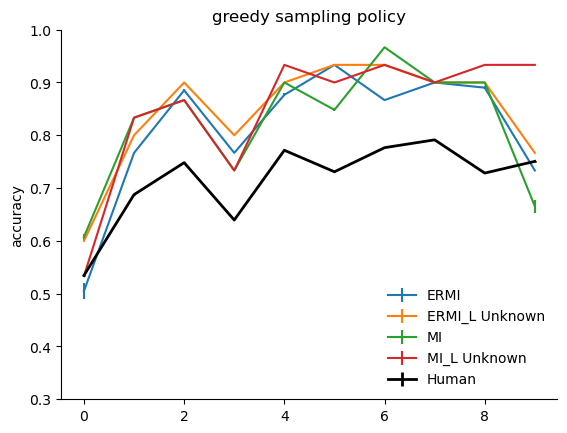

In [10]:
experiment_id=3
num_tasks = data.task.max()+1
policy='greedy'
data = pd.read_csv(f'/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp{experiment_id}.csv')
results_ermi = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
results_mi = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
results_mi_paired_unknown = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_policy=greedy.npz')
results_ermi_paired_unknown = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_simulation/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_policy=greedy.npz')


plt.errorbar(x=np.arange(10), y=(results_ermi['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI')
plt.errorbar(x=np.arange(10), y=(results_ermi_paired_unknown['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_unknown['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI_L Unknown')
plt.errorbar(x=np.arange(10), y=(results_mi['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI')
plt.errorbar(x=np.arange(10), y=(results_mi_paired_unknown['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi_paired_unknown['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI_L Unknown')
plt.errorbar(x=np.arange(10), y=(results_mi_paired_unknown['per_trial_human_accuracy']/num_tasks).mean(0),yerr=(results_mi_paired_unknown['human_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), c='k', lw=2, label='Human')

plt.ylabel('accuracy')
plt.ylim(0.3, 1.) # set y axis limit between 0.5 and 1.
sns.despine()
plt.title(f"{policy} sampling policy")
plt.legend(frameon=False)
plt.show()

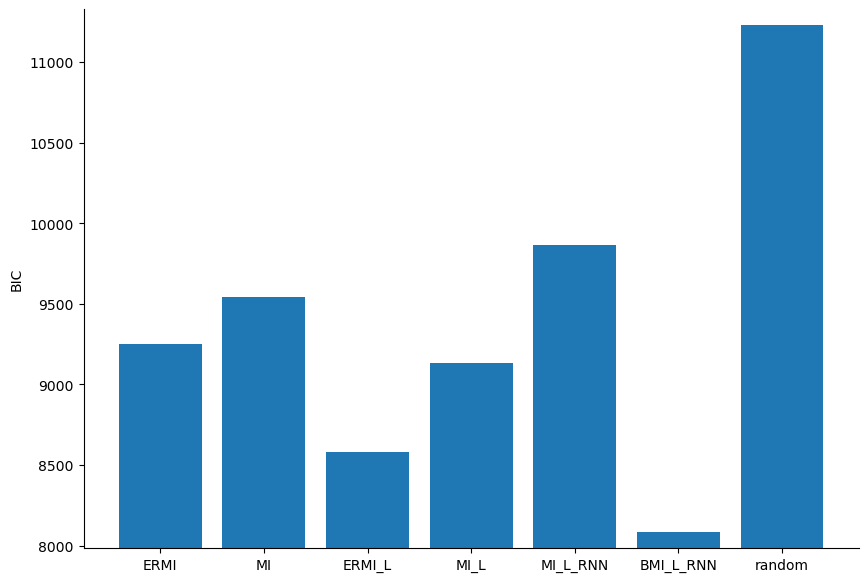

In [76]:
experiment_id=3
data = pd.read_csv(f'/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp{experiment_id}.csv')
num_participants = data.participant.nunique()
num_trials = 300 

# load model fits
results_mi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
results_ermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=True_method=soft_sigmoid_optimizer=de.npz')
results_mi = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=False_method=soft_sigmoid_optimizer=de.npz')
results_ermi = np.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/task=binz2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=False_method=soft_sigmoid_optimizer=de.npz')
logprobs_bmi = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id+1}_bmli.pth')[0]
logprobs_baselines = torch.load(f'/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs{experiment_id+1}_fitted.pth')[0]
logprobs_bmi = torch.cat([logprobs_baselines[:, [0]], logprobs_bmi], dim=-1)
best_logprobs, best_index = torch.max(logprobs_bmi, dim=-1)


# compute BIC
ermi_paired_bic = (2*results_ermi_paired['nlls'] + 1*np.log(num_trials)).sum()
mi_paired_bic = (2*results_mi_paired['nlls']+ 1*np.log(num_trials)).sum() 

ermi_bic = (2*results_ermi['nlls']+ 1*np.log(num_trials)).sum() 
mi_bic = (2*results_mi['nlls']+ 1*np.log(num_trials)).sum() 


rnn_mi_bic = (-2*logprobs_bmi[:, 1] + 1*np.log(num_trials)).sum() 
rnn_bmi_bic = (-2*best_logprobs + 2*np.log(num_trials)).sum()
random_bic = -2*np.log(0.5)*num_trials*num_participants

# pool results
bics = [ermi_bic, mi_bic, ermi_paired_bic, mi_paired_bic, rnn_mi_bic, rnn_bmi_bic, random_bic]
model_names = ['ERMI', 'MI', 'ERMI_L', 'MI_L', 'MI_L_RNN', 'BMI_L_RNN', 'random']

# plot bar plot comparing the two bics
plt.figure(figsize=(10,len(bics)))
plt.bar(model_names, bics)
plt.ylim(min(bics)-100, max(bics)+100)
plt.ylabel('BIC')
sns.despine()

# (interim) Model simulation adn comparison post fixing the normalisation

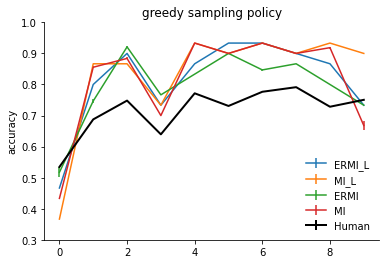

In [3]:
policy='greedy'
data = pd.read_csv('/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp3.csv')
data['correct'] = data['choice']==data['target']
results_ermi = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=256_d_model=64_num_head_pairedFalse_methodgreedy.npz')
results_mi = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_pairedFalse_lossnll_run=test_synthetic_pairedFalse_methodgreedy.npz')
results_ermi_paired_bce = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_pairedTrue_method{policy}.npz')
results_ermi_paired_nll = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_pairedTrue_methodgreedy.npz')
results_ermi_paired_nll_1M = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes1000000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=_pairedTrue_methodgreedy.npz')
results_mi_paired_nll = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_pairedTrue_lossnll_run=1_synthetic_pairedTrue_methodgreedy.npz')
results_mi_paired_bce = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_pairedTrue_run=0_synthetic_pairedTrue_methodgreedy.npz')
results_mi_paired_nll_nonnorm = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_pairedTrue_lossnll_run=2_synthetic_pairedTrue_methodgreedy.npz')
results_ermi_paired_nll_newnorm = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes1000000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=_pairedTrue_methodgreedy.npz')
# results_ermi_paired_nll_newnorm = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes1000000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=_pairedTrue_methodgreedy.npz')

# plot mean accuracy of participants over trials
acc = data.groupby(['participant', 'trial']).correct.mean().reset_index()
# sns.lineplot(data=acc, x='trial', y='correct', errorbar="se", color='k', label="Human")
plt.ylabel('accuracy')
plt.ylim(0.3, 1.) # set y axis limit between 0.5 and 1.
sns.despine()

num_tasks=30
# plt.errorbar(x=np.arange(10), y=(results_ermi_paired_bce['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_bce['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI BMI (BCE)')
# plt.errorbar(x=np.arange(10), y=(results_ermi_paired_nll['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_nll['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI BMI (NLL)')
# plt.errorbar(x=np.arange(10), y=(results_ermi_paired_nll_1M['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_nll_1M['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI BMI (NLL) 1M')
# plt.errorbar(x=np.arange(10), y=(results_ermi['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI')
# plt.errorbar(x=np.arange(10), y=(results_mi['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI')
plt.errorbar(x=np.arange(10), y=(results_ermi_paired_nll_newnorm['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_nll_newnorm['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI_L')
plt.errorbar(x=np.arange(10), y=(results_mi_paired_nll_nonnorm['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi_paired_nll_nonnorm['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI_L')
plt.errorbar(x=np.arange(10), y=(results_ermi['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI')
plt.errorbar(x=np.arange(10), y=(results_mi['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI')

# plt.errorbar(x=np.arange(10), y=(results_mi_paired_nll['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_nll['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI BMI (NLL) w/ schedule free')
# plt.errorbar(x=np.arange(10), y=(results_mi_paired_bce['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_nll['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI BMI (BCE)')
plt.errorbar(x=np.arange(10), y=(results_mi_paired_nll['human_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired_nll['human_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), c='k', lw=2, label='Human')

plt.title(f"{policy} sampling policy")
plt.legend(frameon=False)
plt.show()

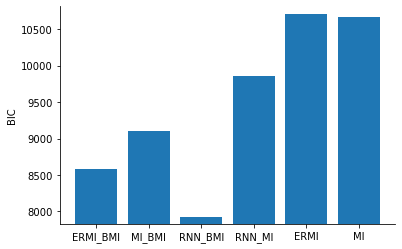

In [4]:
data = pd.read_csv('/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp3.csv')
num_participants = data.participant.nunique() #27
num_trials = 300 

# load model fits
results_mi_matchbmi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_pairedTrue_lossnll_run=2_synthetic_pairedTrue_soft_sigmoid_de.npz')
results_ermi_matchbmi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes1000000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=_pairedTrue_soft_sigmoid_de.npz')
results_mi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=synthetic_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic_pairedFalse_soft_sigmoid_differential_evolution.npz')
results_ermi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_pairedFalse_soft_sigmoid_de.npz')
logprobs_bmi = torch.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs4_bmli.pth')[0]
logprobs_baselines = torch.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs4_fitted.pth')[0]
logprobs_bmi = torch.cat([logprobs_baselines[:, [0]], logprobs_bmi], dim=-1)
best_logprobs, best_index = torch.max(logprobs_bmi, dim=-1)


# compute BIC
ermi_bic = (2*results_ermi['nlls']+ 1*np.log(num_trials)).sum() 
mi_bic = (2*results_mi['nlls']+ 1*np.log(num_trials)).sum() 
ermi_bmi_bic = (2*results_ermi_matchbmi['nlls'] + 1*np.log(num_trials)).sum()
mi_bmi_bic = (2*results_mi_matchbmi['nlls']+ 1*np.log(num_trials)).sum() 
rnn_mi_bic = (-2*logprobs_bmi[:, 1] + 1*np.log(num_trials)).sum() 
bmi_bic = (-2*best_logprobs + 1*np.log(num_trials)).sum()
random_bic = -2*np.log(0.5)*num_trials*num_participants

# pool results
# bics = [ermi_bic, ermi_bmi_bic, mi_bic, mi_bmi_bic, random_bic]
# model_names = ['ERMI', 'ERMI (linear bottleneck)', 'MI', 'MI (linear bottleneck)', 'random']

# bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic]#, random_bic]
# model_names = ['ERMI_BMI', 'MI_BMI',  'RNN_BMI', 'RNN_MI']#, 'random']

bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic, ermi_bic, mi_bic,]#, random_bic]
model_names = ['ERMI_BMI', 'MI_BMI',  'RNN_BMI', 'RNN_MI', 'ERMI', 'MI']#, 'random']


# plot bar plot comparing the two bics
plt.bar(model_names, bics)
plt.ylim(min(bics)-100, max(bics)+100)
plt.ylabel('BIC')
sns.despine()

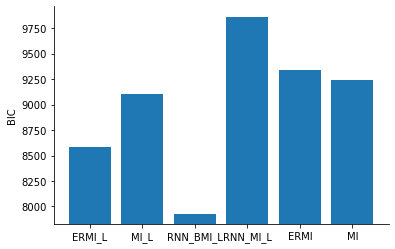

In [7]:
data = pd.read_csv('/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp3.csv')
num_participants = data.participant.nunique() #27
num_trials = 300 

# load model fits
results_mi_matchbmi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_pairedTrue_lossnll_run=2_synthetic_pairedTrue_soft_sigmoid_de.npz')
results_ermi_matchbmi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes1000000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=_pairedTrue_soft_sigmoid_de.npz')

results_mi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_pairedFalse_lossnll_run=test_synthetic_pairedFalse_soft_sigmoid_de.npz')
results_ermi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=256_d_model=64_num_head_pairedFalse_soft_sigmoid_de.npz')

logprobs_bmi = torch.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs4_bmli.pth')[0]
logprobs_baselines = torch.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs4_fitted.pth')[0]
logprobs_bmi = torch.cat([logprobs_baselines[:, [0]], logprobs_bmi], dim=-1)
best_logprobs, best_index = torch.max(logprobs_bmi, dim=-1)


# compute BIC
ermi_bic = (2*results_ermi['nlls']+ 1*np.log(num_trials)).sum() 
mi_bic = (2*results_mi['nlls']+ 1*np.log(num_trials)).sum() 
ermi_bmi_bic = (2*results_ermi_matchbmi['nlls'] + 1*np.log(num_trials)).sum()
mi_bmi_bic = (2*results_mi_matchbmi['nlls']+ 1*np.log(num_trials)).sum() 
rnn_mi_bic = (-2*logprobs_bmi[:, 1] + 1*np.log(num_trials)).sum() 
bmi_bic = (-2*best_logprobs + 1*np.log(num_trials)).sum()
random_bic = -2*np.log(0.5)*num_trials*num_participants

# pool results
# bics = [ermi_bic, ermi_bmi_bic, mi_bic, mi_bmi_bic, random_bic]
# model_names = ['ERMI', 'ERMI (linear bottleneck)', 'MI', 'MI (linear bottleneck)', 'random']

# bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic]#, random_bic]
# model_names = ['ERMI_BMI', 'MI_BMI',  'RNN_BMI', 'RNN_MI']#, 'random']

bics = [ermi_bmi_bic, mi_bmi_bic,  bmi_bic, rnn_mi_bic, ermi_bic, mi_bic,]#, random_bic]
model_names = ['ERMI_L', 'MI_L',  'RNN_BMI_L', 'RNN_MI_L', 'ERMI', 'MI']#, 'random']


# plot bar plot comparing the two bics
plt.bar(model_names, bics)
plt.ylim(min(bics)-100, max(bics)+100)
plt.ylabel('BIC')
sns.despine()

#  model evaluation 

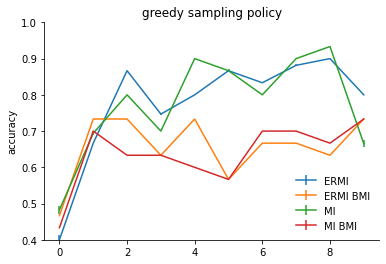

In [4]:
policy='greedy'
data = pd.read_csv('/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp3.csv')
data['correct'] = data['choice']==data['target']
results_ermi = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_pairedFalse_method{policy}.npz')
# results_ermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_pairedTrue_method{policy}.npz')
results_mi = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=synthetic_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic_pairedFalse_method{policy}.npz')
# results_mi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_pairedTrue_run=0_synthetic_pairedTrue_method{policy}.npz')
results_ermi_paired = np.load(f'/u/ajagadish/ermi/decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_pairedTrue_methodgreedy.npz')


# plot mean accuracy of participants over trials
acc = data.groupby(['participant', 'trial']).correct.mean().reset_index()
# sns.lineplot(data=acc, x='trial', y='correct', errorbar="se", color='k', label="Human")
plt.ylabel('accuracy')
plt.ylim(0.4, 1.) # set y axis limit between 0.5 and 1.
sns.despine()

num_tasks=30
plt.errorbar(x=np.arange(10), y=(results_ermi['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI')
plt.errorbar(x=np.arange(10), y=(results_ermi_paired['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI BMI')
plt.errorbar(x=np.arange(10), y=(results_mi['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI')
plt.errorbar(x=np.arange(10), y=(results_mi_paired['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi_paired['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI BMI')
plt.title(f"{policy} sampling policy")
plt.legend(frameon=False)

### over num hidden units

In [42]:
import os
import numpy as np
import torch
import argparse
from tqdm import tqdm
from scipy.optimize import differential_evolution, minimize
import sys
sys.path.insert(0, '/u/ajagadish/ermi/mi')
from envs import Binz2022, Badham2017, Devraj2022
SYS_PATH = '/u/ajagadish/ermi'

In [45]:
files=='.ipynb_checkpoints'

False

In [71]:
files = os.listdir('../decisionmaking/trained_models/')
for file_path in files:
    if file_path=='.ipynb_checkpoints':
        continue
    model_path = f"{'../decisionmaking/trained_models'}/{file_path}"
    model = torch.load(model_path, map_location=torch.device('cpu'))[1]
    print(f"{file_path}: {sum(p.numel() for p in model.parameters())}")

env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_pairedTrue_run=0.pt: 400898
env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=1_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0.pt: 67073
env=synthetic_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=4_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic.pt: 267329
env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic.pt: 400833
env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=3_d_model=64_num_head=8_noise0.0_sh

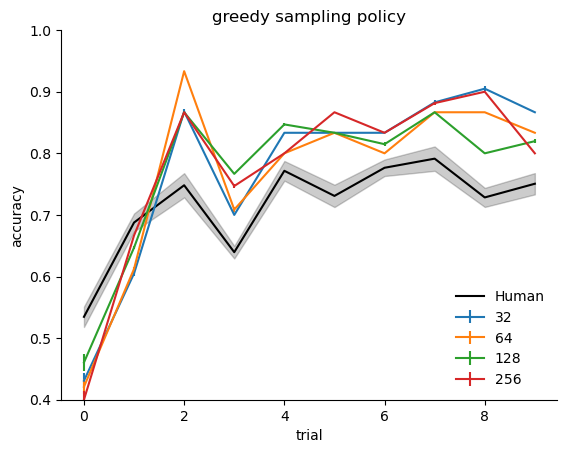

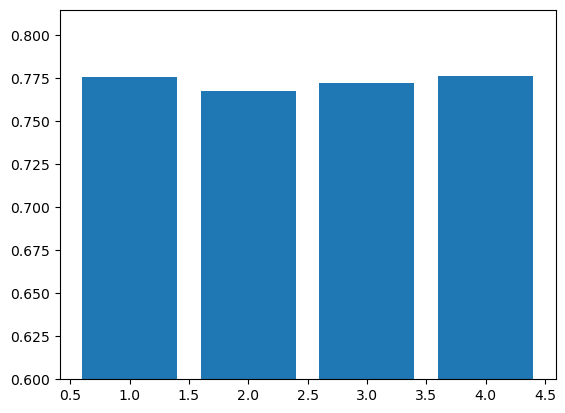

In [33]:
policy='greedy'
data = pd.read_csv('/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp3.csv')
data['correct'] = data['choice']==data['target']
results1 = np.load(f'../decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes500000_num_hidden=32_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_pairedFalse_methodgreedy.npz')
results2 = np.load(f'../decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes500000_num_hidden=64_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_pairedFalse_methodgreedy.npz')
results3 = np.load(f'../decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes500000_num_hidden=128_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0._pairedFalse_methodgreedy.npz')
results4 = np.load(f'../decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_pairedFalse_methodgreedy.npz')

# plot mean accuracy of participants over trials
acc = data.groupby(['participant', 'trial']).correct.mean().reset_index()
sns.lineplot(data=acc, x='trial', y='correct', errorbar="se", color='k', label="Human")
plt.ylabel('accuracy')
plt.ylim(0.4, 1.) # set y axis limit between 0.5 and 1.
sns.despine()

num_tasks=30
plt.errorbar(x=np.arange(10), y=(results1['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results1['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='32')
plt.errorbar(x=np.arange(10), y=(results2['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results2['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='64')
plt.errorbar(x=np.arange(10), y=(results3['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results3['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='128')
plt.errorbar(x=np.arange(10), y=(results4['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results4['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='256')
plt.title(f"{policy} sampling policy")
plt.legend(frameon=False)
plt.show()

plt.bar(np.arange(1,5), [results1['model_accuracy'].mean(), results2['model_accuracy'].mean(),results3['model_accuracy'].mean(),results4['model_accuracy'].mean()])
plt.ylim(0.6)
plt.show()

## over layers

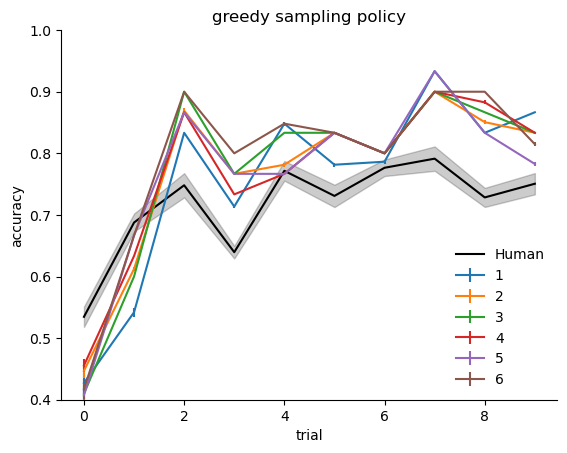

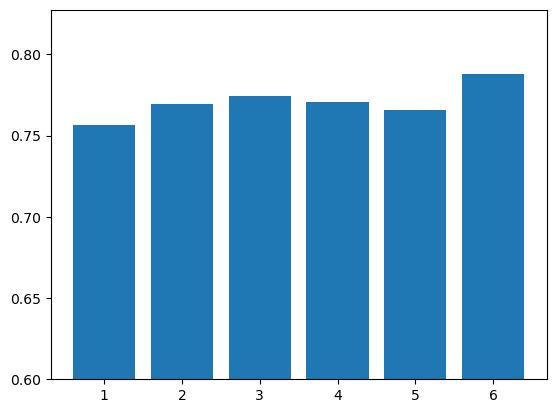

In [31]:
policy='greedy'
data = pd.read_csv('/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp3.csv')
data['correct'] = data['choice']==data['target']
results1 = np.load(f'../decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=1_d_model=64_num_head=8_noise0._pairedFalse_methodgreedy.npz')
results2 = np.load(f'../decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=2_d_model=64_num_head=8_noise0._pairedFalse_methodgreedy.npz')
results3 = np.load(f'../decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=3_d_model=64_num_head=8_noise0._pairedFalse_methodgreedy.npz')
results4 = np.load(f'../decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=4_d_model=64_num_head=8_noise0._pairedFalse_methodgreedy.npz')
results5 = np.load(f'../decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=5_d_model=64_num_head=8_noise0._pairedFalse_methodgreedy.npz')
results6 = np.load(f'../decisionmaking/data/evaluation/evaluate_binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0._pairedFalse_methodgreedy.npz')

# plot mean accuracy of participants over trials
acc = data.groupby(['participant', 'trial']).correct.mean().reset_index()
sns.lineplot(data=acc, x='trial', y='correct', errorbar="se", color='k', label="Human")
plt.ylabel('accuracy')
plt.ylim(0.4, 1.) # set y axis limit between 0.5 and 1.
sns.despine()

num_tasks=30
plt.errorbar(x=np.arange(10), y=(results1['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results1['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='1')
plt.errorbar(x=np.arange(10), y=(results2['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results2['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='2')
plt.errorbar(x=np.arange(10), y=(results3['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results3['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='3')
plt.errorbar(x=np.arange(10), y=(results4['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results4['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='4')
plt.errorbar(x=np.arange(10), y=(results5['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results5['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='5')
plt.errorbar(x=np.arange(10), y=(results6['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results6['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='6')

plt.title(f"{policy} sampling policy")
plt.legend(frameon=False)
plt.show()

plt.bar(np.arange(1,7), [results1['model_accuracy'].mean(), results2['model_accuracy'].mean(),results3['model_accuracy'].mean(),results4['model_accuracy'].mean(),results5['model_accuracy'].mean(),results6['model_accuracy'].mean()])
plt.ylim(0.6)
plt.show()

0.7565432

# model comparison binz2022

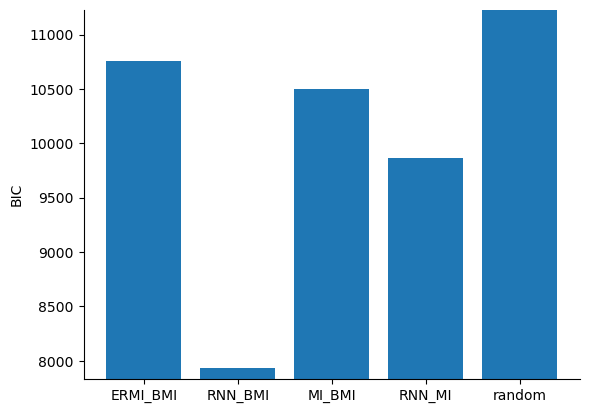

In [25]:
data = pd.read_csv('/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp3.csv')
num_participants = data.participant.nunique() #27
num_trials = 300 

# load model fits
results_mi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/{}.npz')
results_ermi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/{}.npz')
results_mi_matchbmi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/{}.npz')
results_ermi_matchbmi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/{}.npz')

# compute BIC
ermi_bic = (2*results_ermi['nlls']+ 1*np.log(num_trials)).sum() 
mi_bic = (2*results_mi['nlls']+ 1*np.log(num_trials)).sum() 
ermi_bmi_bic = (2*results_mi_matchbmi['nlls'] + 1*np.log(num_trials)).sum()
mi_bmi_bic = (2*results_mi_matchbmi['nlls']+ 1*np.log(num_trials)).sum() 
random_bic = -2*np.log(0.5)*num_trials*num_participants

# pool results
bics = [ermi_bic, ermi_bmi_bic, mi_bic, mi_bmi_bic, random_bic]
model_names = ['ERMI', 'ERMI (linear bottleneck)', 'MI', 'MI (linear bottleneck)', 'random']

# plot bar plot comparing the two bics
plt.bar(model_names, bics)
plt.ylim(min(bics)-100, max(bics))
plt.ylabel('BIC')
sns.despine()

## archive

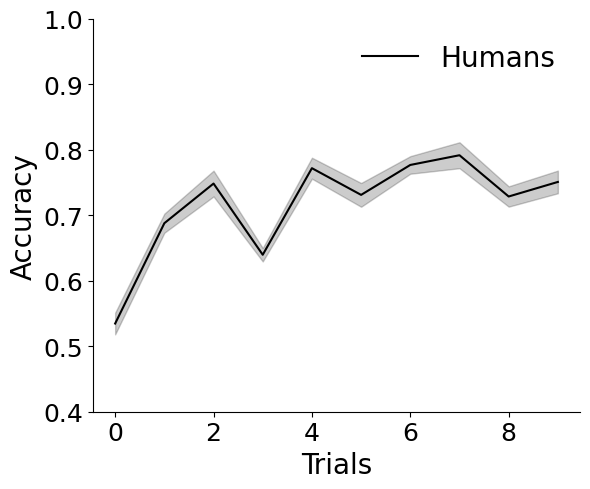

In [13]:
data = pd.read_csv('/u/ajagadish/ermi/decisionmaking/data/human/binz2022heuristics_exp4.csv')
data['correct'] = data['choice']==data['target']

# results_ermi = np.load('/u/ajagadish/ermi/decisionmaking/data/evaluation/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_pairedFalse_methodbinomial.npz')
# results_ermi_paired = np.load('/u/ajagadish/ermi/decisionmaking/data/evaluation/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_pairedTrue_methodbinomial.npz')
# results_mi = np.load('../decisionmaking/data/evaluation/binz2022_env=synthetic_model=transformer_num_episodes500000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic_pairedFalse_methodbinomial.npz')
# results_mi_paired = np.load('../decisionmaking/data/evaluation/binz2022_env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_pairedTrue_run=0_synthetic_pairedTrue_methodbinomial.npz')

# plot mean accuracy of participants over trials
acc = data.groupby(['participant', 'trial']).correct.mean().reset_index()
FIGSIZE = (6,5)
FONTSIZE = 20
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
sns.lineplot(data=acc, x='trial', y='correct', errorbar="se", color='k', label="Humans", ax=ax)
ax.set_xlabel('Trials', fontsize=FONTSIZE)
ax.set_ylabel('Accuracy', fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE-2)
plt.xticks(fontsize=FONTSIZE-2)
plt.ylim(0.4, 1.) # set y axis limit between 0.5 and 1.
sns.despine()
f.tight_layout()
plt.legend(frameon=False,fontsize=FONTSIZE)
plt.show()

# num_tasks=30
# plt.errorbar(x=np.arange(10), y=(results_ermi['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI')
# plt.errorbar(x=np.arange(10), y=(results_ermi_paired['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_ermi_paired['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='ERMI BMI')
# plt.errorbar(x=np.arange(10), y=(results_mi['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI')
# plt.errorbar(x=np.arange(10), y=(results_mi_paired['per_trial_model_accuracy']/num_tasks).mean(0),yerr=(results_mi_paired['per_trial_model_accuracy']/num_tasks).std(0)/np.sqrt(num_tasks), label='MI BMI')



In [ ]:
dim=4
env_name = f'{SYS_PATH}/decisionmaking/data/real_data_dim{dim}'
data = pd.read_csv(f'{env_name}.csv')
data.input = data['input'].apply(lambda x: np.array(eval(x)))
data.input = data.input.apply(np.random.permutation)

In [ ]:
data

,Unnamed: 0,input,target,trial_id,task_id
0,0,"[0.14798207581043243, 0.5135135054588318, 0.52...",[0.5],0,0
1,1,"[0.37162163853645325, 0.0796460211277008, 0.35...",[0.21428571],1,0
2,2,"[0.11946903169155121, 0.20777279138565063, 0.6...",[0.28571429],2,0
3,3,"[0.4932432472705841, 0.11061947047710419, 0.15...",[0.32142857],3,0
4,4,"[0.33613449335098267, 0.3445946276187897, 0.05...",[0.21428571],4,0
...,...,...,...,...,...
518404,518404,"[0.27085554599761963, 0.5055238008499146, 0.69...",[0.70813192],15,25904
518405,518405,"[0.24119353294372559, 0.4036314785480499, 0.36...",[0.87087504],16,25904
518406,518406,"[0.6817532777786255, 0.4184124767780304, 0.241...",[0.74661996],17,25904
518407,518407,"[0.29222261905670166, 0.39343854784965515, 0.3...",[0.81474917],18,25904


In [ ]:
dim=2
env_name = f'{SYS_PATH}/decisionmaking/data/synthetic_decisionmaking_tasks_dim{dim}_data20_tasks10'
data = pd.read_csv(f'{env_name}.csv')
data.input = data['input'].apply(lambda x: np.array(eval(x)))
data.input = data.input.apply(np.random.permutation)
data.target = data['target'].apply(lambda x: np.array(eval(x)))

In [ ]:
data = data[data.task_id==1]

In [ ]:
np.stack(-data.target.values).reshape(-1).mean()

-0.17603835687041283

In [ ]:
aa = np.asarray([[0.43333334, 0.6333333 , 0.53333336, 0.6666667 , 0.6333333 ,
        0.73333335, 0.7       , 0.8333333 , 0.8       , 0.8666667 ],
       [0.5       , 0.6333333 , 0.6       , 0.6333333 , 0.8       ,
        0.8       , 0.73333335, 0.8333333 , 0.8       , 0.8       ],
       [0.4       , 0.56666666, 0.6333333 , 0.7       , 0.76666665,
        0.76666665, 0.8666667 , 0.76666665, 0.73333335, 0.76666665],
       [0.46666667, 0.56666666, 0.73333335, 0.7       , 0.73333335,
        0.8       , 0.76666665, 0.8666667 , 0.8666667 , 0.76666665],
       [0.43333334, 0.5       , 0.9       , 0.6666667 , 0.76666665,
        0.73333335, 0.8333333 , 0.8       , 0.8333333 , 0.76666665],
       [0.43333334, 0.56666666, 0.76666665, 0.53333336, 0.76666665,
        0.7       , 0.6666667 , 0.8       , 0.6333333 , 0.76666665],
       [0.46666667, 0.5       , 0.6666667 , 0.6333333 , 0.8333333 ,
        0.76666665, 0.8       , 0.8333333 , 0.73333335, 0.7       ],
       [0.43333334, 0.56666666, 0.73333335, 0.56666666, 0.7       ,
        0.8       , 0.73333335, 0.8       , 0.7       , 0.8666667 ],
       [0.6       , 0.6333333 , 0.8333333 , 0.6       , 0.8       ,
        0.6333333 , 0.7       , 0.6666667 , 0.8       , 0.8666667 ],
       [0.43333334, 0.4       , 0.76666665, 0.6333333 , 0.8333333 ,
        0.6333333 , 0.8333333 , 0.9       , 0.76666665, 0.73333335],
       [0.4       , 0.56666666, 0.8       , 0.6666667 , 0.8       ,
        0.6666667 , 0.7       , 0.8333333 , 0.76666665, 0.8333333 ],
       [0.4       , 0.4       , 0.76666665, 0.6666667 , 0.73333335,
        0.76666665, 0.7       , 0.9       , 0.76666665, 0.6666667 ],
       [0.36666667, 0.7       , 0.73333335, 0.6666667 , 0.6666667 ,
        0.76666665, 0.76666665, 0.8333333 , 0.8       , 0.8       ],
       [0.43333334, 0.6333333 , 0.6666667 , 0.6       , 0.8       ,
        0.76666665, 0.7       , 0.76666665, 0.7       , 0.8333333 ],
       [0.5       , 0.6333333 , 0.7       , 0.6666667 , 0.73333335,
        0.8       , 0.7       , 0.6666667 , 0.6666667 , 0.8       ],
       [0.33333334, 0.5       , 0.6333333 , 0.7       , 0.8333333 ,
        0.6666667 , 0.6       , 0.76666665, 0.8666667 , 0.8       ],
       [0.4       , 0.6666667 , 0.8666667 , 0.53333336, 0.76666665,
        0.6666667 , 0.9       , 0.73333335, 0.6666667 , 0.76666665],
       [0.33333334, 0.53333336, 0.76666665, 0.56666666, 0.8333333 ,
        0.76666665, 0.7       , 0.9       , 0.73333335, 0.7       ],
       [0.53333336, 0.6       , 0.7       , 0.7       , 0.76666665,
        0.6333333 , 0.73333335, 0.93333334, 0.73333335, 0.73333335],
       [0.4       , 0.56666666, 0.8333333 , 0.56666666, 0.73333335,
        0.7       , 0.73333335, 0.73333335, 0.8       , 0.76666665],
       [0.33333334, 0.6333333 , 0.73333335, 0.7       , 0.76666665,
        0.8666667 , 0.56666666, 0.9       , 0.8333333 , 0.76666665],
       [0.4       , 0.6333333 , 0.8       , 0.7       , 0.8333333 ,
        0.6       , 0.7       , 0.8333333 , 0.8666667 , 0.7       ],
       [0.4       , 0.5       , 0.8       , 0.73333335, 0.73333335,
        0.73333335, 0.6666667 , 0.7       , 0.8666667 , 0.8333333 ],
       [0.6       , 0.6333333 , 0.8666667 , 0.6       , 0.76666665,
        0.7       , 0.6333333 , 0.8       , 0.76666665, 0.73333335],
       [0.4       , 0.73333335, 0.73333335, 0.6333333 , 0.73333335,
        0.7       , 0.7       , 0.9       , 0.8666667 , 0.8666667 ],
       [0.4       , 0.7       , 0.76666665, 0.6666667 , 0.76666665,
        0.6666667 , 0.6666667 , 0.76666665, 0.6666667 , 0.73333335],
       [0.33333334, 0.6       , 0.76666665, 0.56666666, 0.8666667 ,
        0.6666667 , 0.8       , 0.9       , 0.8333333 , 0.8       ]])

In [ ]:
# NEW ERMI MODEL
aa = np.asarray([[0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667],
        [0.4667, 0.7000, 0.6667, 0.5667, 0.7000, 0.4667, 0.6000, 0.6000, 0.6333,
         0.6667]])

In [ ]:
bb = np.asarray([[0.6333333 , 0.6       , 0.73333335, 0.53333336, 0.8666667 ,
        0.73333335, 0.8333333 , 0.8666667 , 0.8333333 , 0.56666666],
       [0.56666666, 0.43333334, 0.7       , 0.73333335, 0.8666667 ,
        0.8       , 0.76666665, 0.93333334, 0.8333333 , 0.43333334],
       [0.53333336, 0.6666667 , 0.6666667 , 0.53333336, 0.76666665,
        0.73333335, 0.76666665, 0.8666667 , 0.9       , 0.6666667 ],
       [0.53333336, 0.5       , 0.6666667 , 0.6666667 , 0.7       ,
        0.6666667 , 0.6333333 , 0.9       , 0.8666667 , 0.6       ],
       [0.56666666, 0.7       , 0.6333333 , 0.7       , 0.8       ,
        0.73333335, 0.8       , 0.9       , 0.8333333 , 0.6333333 ],
       [0.46666667, 0.5       , 0.76666665, 0.6       , 0.8       ,
        0.8333333 , 0.6       , 0.96666664, 0.8       , 0.6333333 ],
       [0.73333335, 0.46666667, 0.7       , 0.6666667 , 0.8333333 ,
        0.8       , 0.76666665, 0.8       , 0.8333333 , 0.73333335],
       [0.56666666, 0.6666667 , 0.56666666, 0.6333333 , 0.8       ,
        0.6666667 , 0.8       , 0.8333333 , 0.8       , 0.6333333 ],
       [0.56666666, 0.6       , 0.73333335, 0.56666666, 0.8666667 ,
        0.7       , 0.8333333 , 0.8       , 0.73333335, 0.6       ],
       [0.4       , 0.7       , 0.7       , 0.56666666, 0.8333333 ,
        0.8666667 , 0.8       , 0.8333333 , 0.93333334, 0.6333333 ],
       [0.4       , 0.6       , 0.7       , 0.6333333 , 0.8333333 ,
        0.76666665, 0.6333333 , 0.8333333 , 0.9       , 0.6333333 ],
       [0.56666666, 0.6333333 , 0.73333335, 0.5       , 0.8       ,
        0.76666665, 0.8333333 , 0.8333333 , 0.8333333 , 0.6666667 ],
       [0.4       , 0.6666667 , 0.6333333 , 0.53333336, 0.9       ,
        0.73333335, 0.76666665, 0.9       , 0.8666667 , 0.73333335],
       [0.46666667, 0.6333333 , 0.73333335, 0.6666667 , 0.8       ,
        0.73333335, 0.8666667 , 0.8666667 , 0.9       , 0.56666666],
       [0.46666667, 0.6333333 , 0.8       , 0.73333335, 0.8333333 ,
        0.6333333 , 0.8333333 , 0.8333333 , 0.8       , 0.6666667 ],
       [0.53333336, 0.56666666, 0.8       , 0.56666666, 0.93333334,
        0.73333335, 0.8       , 0.9       , 0.8666667 , 0.7       ],
       [0.5       , 0.6666667 , 0.76666665, 0.6       , 0.73333335,
        0.7       , 0.8333333 , 0.9       , 0.93333334, 0.6       ],
       [0.56666666, 0.56666666, 0.8       , 0.56666666, 0.8       ,
        0.76666665, 0.8333333 , 0.93333334, 0.96666664, 0.6333333 ],
       [0.6333333 , 0.6333333 , 0.6       , 0.6       , 0.9       ,
        0.8       , 0.8666667 , 0.93333334, 0.8666667 , 0.56666666],
       [0.46666667, 0.7       , 0.73333335, 0.53333336, 0.8333333 ,
        0.6666667 , 0.76666665, 0.76666665, 0.8333333 , 0.56666666],
       [0.56666666, 0.43333334, 0.6       , 0.56666666, 0.8333333 ,
        0.6333333 , 0.8333333 , 0.8333333 , 0.8333333 , 0.6666667 ],
       [0.43333334, 0.6333333 , 0.6333333 , 0.56666666, 0.8666667 ,
        0.8333333 , 0.8666667 , 0.96666664, 0.8       , 0.53333336],
       [0.43333334, 0.56666666, 0.6333333 , 0.7       , 0.8333333 ,
        0.8       , 0.76666665, 0.8666667 , 0.9       , 0.6       ],
       [0.46666667, 0.46666667, 0.73333335, 0.6333333 , 0.8       ,
        0.76666665, 0.8666667 , 0.9       , 0.8666667 , 0.6       ],
       [0.6       , 0.46666667, 0.6666667 , 0.6666667 , 0.73333335,
        0.6666667 , 0.76666665, 0.8333333 , 0.8333333 , 0.6333333 ],
       [0.6333333 , 0.53333336, 0.8333333 , 0.53333336, 0.73333335,
        0.8666667 , 0.8333333 , 0.8       , 0.8       , 0.43333334],
       [0.43333334, 0.6666667 , 0.8       , 0.6333333 , 0.73333335,
        0.8333333 , 0.8       , 0.8666667 , 0.8666667 , 0.7       ]])

In [ ]:
bb = np.asarray([[0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333],
        [0.4667, 0.7333, 0.6667, 0.6333, 0.7000, 0.5000, 0.6667, 0.7000, 0.6333,
         0.7333]])

In [ ]:
# ERMI shuffled
aa = np.asarray([[0.4000, 0.6000, 0.7333, 0.5333, 0.7333, 0.7667, 0.7000, 0.8333, 0.6667,
         0.8000],
        [0.3667, 0.6000, 0.7000, 0.7000, 0.8000, 0.7333, 0.6333, 0.8000, 0.7333,
         0.8000],
        [0.4333, 0.6333, 0.6333, 0.5000, 0.6667, 0.7333, 0.6667, 0.8333, 0.8333,
         0.8000],
        [0.5000, 0.6000, 0.6000, 0.6667, 0.5667, 0.8333, 0.7333, 0.8333, 0.8333,
         0.8333],
        [0.3667, 0.4667, 0.7333, 0.6000, 0.8333, 0.7333, 0.5667, 0.9000, 0.6667,
         0.8000],
        [0.4667, 0.6333, 0.6333, 0.5333, 0.7000, 0.7333, 0.8333, 0.8667, 0.7333,
         0.7000],
        [0.4000, 0.5667, 0.7333, 0.6667, 0.7333, 0.8667, 0.5333, 0.8000, 0.6667,
         0.8667],
        [0.3667, 0.5667, 0.6333, 0.4667, 0.5667, 0.6667, 0.6333, 0.8667, 0.8333,
         0.7667],
        [0.4667, 0.5667, 0.8000, 0.5667, 0.6000, 0.6000, 0.7000, 0.8333, 0.7333,
         0.8333],
        [0.3333, 0.4667, 0.8667, 0.5667, 0.7667, 0.6667, 0.7667, 0.8000, 0.7667,
         0.7667],
        [0.4667, 0.4333, 0.7000, 0.4667, 0.6667, 0.8333, 0.6667, 0.7667, 0.8000,
         0.6667],
        [0.4333, 0.5333, 0.6000, 0.6333, 0.8000, 0.8000, 0.7667, 0.8333, 0.7333,
         0.7333],
        [0.5000, 0.5667, 0.6667, 0.7000, 0.6333, 0.7000, 0.7667, 0.8000, 0.8333,
         0.8000],
        [0.5333, 0.6667, 0.6667, 0.6333, 0.7000, 0.8000, 0.7333, 0.7667, 0.8667,
         0.8000],
        [0.5333, 0.6667, 0.5667, 0.5333, 0.7667, 0.7667, 0.5333, 0.8000, 0.7000,
         0.9000],
        [0.4667, 0.6000, 0.7000, 0.6000, 0.7000, 0.8000, 0.7000, 0.9000, 0.7667,
         0.7333],
        [0.4667, 0.5667, 0.7667, 0.6667, 0.6667, 0.8667, 0.7333, 0.9000, 0.7667,
         0.8000],
        [0.3333, 0.5000, 0.7000, 0.5667, 0.7667, 0.7667, 0.6667, 0.9333, 0.9000,
         0.8667],
        [0.3000, 0.6667, 0.7000, 0.6333, 0.6667, 0.8333, 0.7333, 0.7333, 0.7000,
         0.7333],
        [0.2667, 0.4000, 0.6000, 0.5667, 0.7333, 0.7667, 0.7333, 0.9000, 0.8667,
         0.7667],
        [0.3333, 0.5000, 0.7667, 0.7000, 0.7333, 0.6000, 0.5333, 0.9000, 0.6667,
         0.7667],
        [0.4333, 0.5667, 0.7333, 0.7333, 0.8667, 0.7333, 0.7000, 0.7667, 0.8000,
         0.8667],
        [0.5333, 0.5000, 0.8333, 0.5667, 0.7333, 0.7667, 0.7000, 0.8667, 0.7333,
         0.7667],
        [0.4333, 0.5333, 0.5333, 0.6333, 0.6667, 0.7667, 0.7333, 0.8333, 0.7667,
         0.8333],
        [0.4000, 0.6333, 0.6000, 0.6000, 0.7667, 0.7333, 0.7667, 0.7667, 0.7667,
         0.9000],
        [0.5000, 0.6000, 0.6667, 0.6000, 0.6667, 0.7000, 0.8333, 0.7667, 0.8667,
         0.8000],
        [0.4333, 0.6667, 0.7000, 0.6333, 0.7000, 0.7333, 0.6667, 0.7333, 0.7667,
         0.6333]])

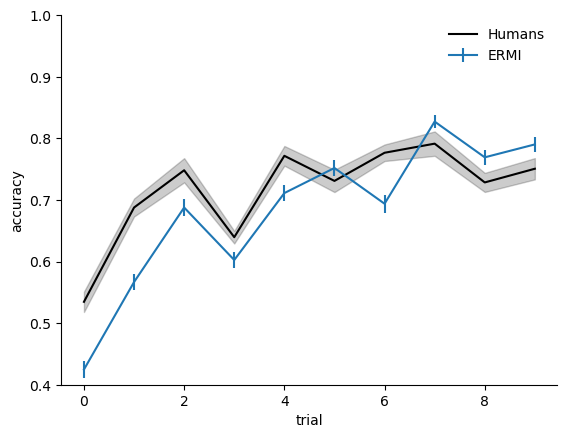

In [ ]:
# greedy policy
sns.lineplot(data=acc, x='trial', y='correct', errorbar="se", color='k', label='Humans')
plt.errorbar(x=np.arange(10), y=aa.mean(0),yerr=aa.std(0)/np.sqrt(30), label='ERMI')
plt.legend(frameon=False)
plt.ylabel('accuracy')
plt.ylim(0.4, 1.) # set y axis limit between 0.5 and 1.
sns.despine()

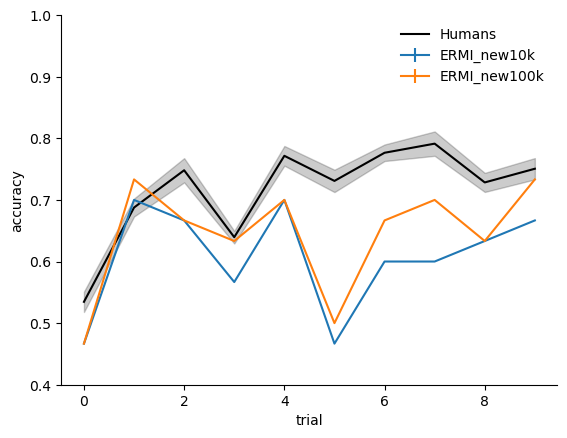

In [ ]:
# binomial smapling policy
plt.errorbar(x=np.arange(10), y=aa.mean(0),yerr=aa.std(0)/np.sqrt(30), label='ERMI_new10k')
plt.errorbar(x=np.arange(10), y=bb.mean(0),yerr=bb.std(0)/np.sqrt(30), label='ERMI_new100k')
# plt.plot([0.44444444, 0.59012346, 0.74320988, 0.62592593, 0.74320988,
#        0.72098765, 0.74074074, 0.82222222, 0.71851852, 0.76790123], label='ERMI (100k)') 
sns.lineplot(data=acc, x='trial', y='correct', errorbar="se", color='k', label='Humans')
plt.legend(frameon=False)
plt.ylabel('accuracy')
plt.ylim(0.4, 1.) # set y axis limit between 0.5 and 1.
sns.despine()

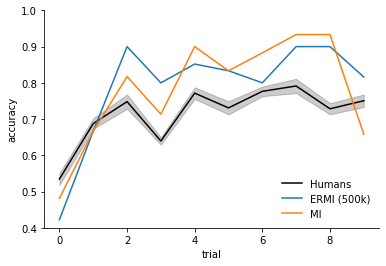

In [ ]:
# greedy policy
sns.lineplot(data=acc, x='trial', y='correct', errorbar="se", color='k', label='Humans')
plt.plot([0.42222222, 0.66666667, 0.9       , 0.8       , 0.85185185,
       0.83333333, 0.8       , 0.9       , 0.9       , 0.81604938], label='ERMI (500k)')

plt.plot([0.48148148, 0.66666667, 0.81728395, 0.71358025, 0.9       ,
       0.83333333, 0.88271605, 0.93333333, 0.93333333, 0.65802469], label='MI')
plt.legend(frameon=False)
plt.ylabel('accuracy')
plt.ylim(0.4, 1.) # set y axis limit between 0.5 and 1.
sns.despine()

In [ ]:
ermi_modelfits = [
    (169.5673370361328, [0.33255378]),
    (142.01544189453125, [0.71602505]),
    (183.84768676757812, [0.41944356]),
    (166.8855743408203, [0.43992458]),
    (175.94314575195312, [0.30635112]),
    (157.6065673828125, [0.52620444]),
    (176.923095703125, [0.40333852]),
    (166.6994171142578, [0.43336525]),
    (186.2415771484375, [0.30240063]),
    (152.73886108398438, [0.56479406]),
    (151.4681396484375, [0.59552636]),
    (205.68666076660156, [0.04403305]),
    (170.4123077392578, [0.40618964]),
    (181.92994689941406, [0.43657759]),
    (172.97019958496094, [0.33907086]),
    (177.1389617919922, [0.30561235]),
    (169.86874389648438, [0.36272536]),
    (189.55308532714844, [0.27757055]),
    (189.90966796875, [0.25836013]),
    (170.335693359375, [0.56185734]),
    (188.8916778564453, [0.23787275]),
    (162.29110717773438, [0.45405818]),
    (161.36407470703125, [0.42467121]),
    (156.70956420898438, [0.54853487]),
    (193.26243591308594, [0.19274343]),
    (171.58961486816406, [0.4100367]),
    (192.3779296875, [0.21571546])
]
betas = [beta[1] for beta in ermi_modelfits]
nlls_ermi = np.stack([nll[0] for nll in ermi_modelfits])

In [ ]:
results_mi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_synthetic_soft_sigmoid_differential_evolution.npz')
results_ermi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0._soft_sigmoid_differential_evolution.npz')

In [ ]:
results_mi_matchbmi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=synthetic_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_pairedTrue_run=0_synthetic_soft_sigmoid_differential_evolution.npz')
results_ermi_matchbmi = np.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_unknown_model=transformer_num_episodes10000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8__soft_sigmoid_differential_evolution.npz')

In [ ]:
logprobs_bmi = torch.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs4_bmli.pth')[0]
logprobs_baselines = torch.load('/u/ajagadish/ermi/decisionmaking/data/model_comparison/logprobs4_fitted.pth')[0]
logprobs_bmi = torch.cat([logprobs_baselines[:, [0]], logprobs_bmi], dim=-1)
best_logprobs, best_index = torch.max(logprobs_bmi, dim=-1)

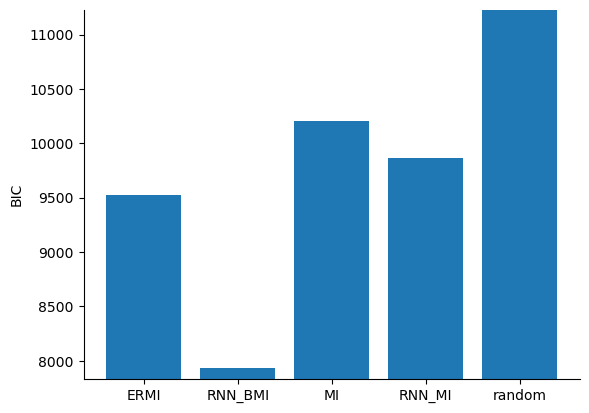

In [ ]:
num_participants = 27 #data.participant.nunique()
num_trials = 300
ermi_bic = (2*nlls_ermi+ 1*np.log(num_trials)).sum() 
# ermi_bic = (2*results_ermi['nlls']+ 1*np.log(num_trials)).sum() 
mi_bic = (2*results_mi['nlls'] + 1*np.log(num_trials)).sum()
rnn_mi_bic = (-2*logprobs_bmi[:, 1] + 1*np.log(num_trials)).sum() 
bmi_bic = (-2*best_logprobs + 1*np.log(num_trials)).sum()
random_bic = -2*np.log(0.5)*num_trials*num_participants
bics = [ermi_bic, bmi_bic, mi_bic, rnn_mi_bic, random_bic]
model_names = ['ERMI', 'RNN_BMI', 'MI', 'RNN_MI', 'random']
# plot bar plot comparing the two bics
plt.bar(model_names, bics)
plt.ylim(min(bics)-100, max(bics))
plt.ylabel('BIC')
sns.despine()

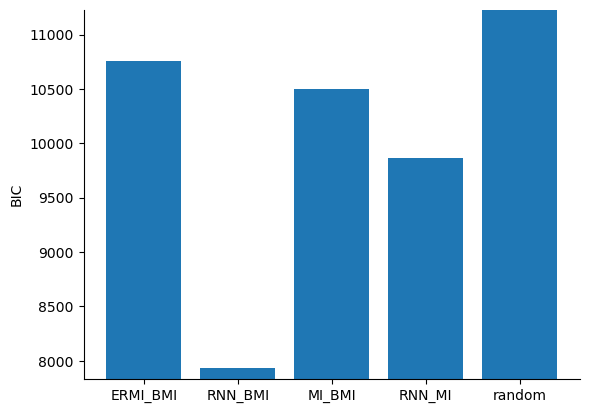

In [ ]:
num_participants = 27 #data.participant.nunique()
num_trials = 300
# ermi_bic = (2*nlls_ermi+ 1*np.log(num_trials)).sum() 
ermi_bic = (2*results_ermi_matchbmi['nlls']+ 1*np.log(num_trials)).sum() 
mi_bic = (2*results_mi_matchbmi['nlls'] + 1*np.log(num_trials)).sum()
rnn_mi_bic = (-2*logprobs_bmi[:, 1] + 1*np.log(num_trials)).sum() 
bmi_bic = (-2*best_logprobs + 1*np.log(num_trials)).sum()
random_bic = -2*np.log(0.5)*num_trials*num_participants
bics = [ermi_bic, bmi_bic, mi_bic, rnn_mi_bic, random_bic]
model_names = ['ERMI_BMI', 'RNN_BMI', 'MI_BMI', 'RNN_MI', 'random']
# plot bar plot comparing the two bics
plt.bar(model_names, bics)
plt.ylim(min(bics)-100, max(bics))
plt.ylabel('BIC')
sns.despine()

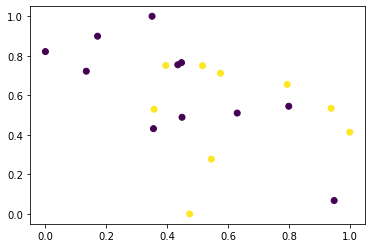

In [ ]:
plt.scatter(np.stack(data.input.values)[:,0], np.stack(data.input.values)[:,1], c=-np.stack(data.target.values)>=0)

# data stats

In [22]:
mode=0
dim=2
condition = 'unknown'
color_stats = '#405A63' 

# stats = np.load(
# f'{SYS_PATH}/decisionmaking/data/stats/stats_{str(mode)}_{str(dim)}_{condition}.npz', allow_pickle=True)
# all_corr, gini_coeff, posterior_logprob, all_accuraries_linear = stats['all_corr'], stats[
# 'gini_coeff'], stats['posterior_logprob'], stats['all_accuraries_linear']
# all_accuraries_polynomial, all_targets_with_norm, all_features_with_norm, sign_coeff, direction_coeff = stats[
# 'all_accuraries_polynomial'], stats['all_targets_with_norm'], stats['all_features_with_norm'], stats['sign_coeff'], stats['direction_coeff']

stats = np.load(
f'{SYS_PATH}/decisionmaking/data/stats/stats_2.npz', allow_pickle=True)
all_corr, gini_coeff, posterior_logprob, all_accuraries_linear = stats['all_corr'], stats[
'gini_coeff'], stats['posterior_logprob'], stats['all_accuraries_linear']
all_accuraries_polynomial, all_targets_with_norm, all_features_with_norm, sign_coeff, direction_coeff = stats[
'all_accuraries_polynomial'], stats['all_targets_with_norm'], stats['all_features_with_norm'], stats['sign_coeff'], stats['direction_coeff']

gini_coeff = np.array(gini_coeff)
gini_coeff = gini_coeff[~np.isnan(gini_coeff)]
all_corr = np.array(all_corr)
sign_coeff = np.array(sign_coeff)
direction_coeff = np.stack(direction_coeff)

FONTSIZE = 22  # 8
fig, axs = plt.subplots(1, 4,  figsize=(6*4, 4))  # figsize=(6.75, 1.5))
sns.histplot(all_corr.reshape(-1), ax=axs[0], bins=11, binrange=(
        -1., 1.), stat='probability', edgecolor='w', linewidth=1, color=color_stats, alpha=1.)
sns.histplot(gini_coeff, ax=axs[1], bins=11, binrange=(
        0., gini_coeff.max()), stat='probability', edgecolor='w', linewidth=1, color=color_stats, alpha=1.)
sns.histplot(np.argmax(np.abs(direction_coeff), axis=1), ax=axs[2], bins=dim, binrange=(
        -0.5, dim-0.5), stat='probability', edgecolor='w', linewidth=1, color=color_stats, alpha=1.)
sns.histplot(sign_coeff.reshape(-1), ax=axs[3], bins=3, binrange=(
        -1.5, 1.5), stat='probability', edgecolor='w', linewidth=1, color=color_stats, alpha=1.)

axs[0].set_ylim(0, .4)
axs[1].set_ylim(0, .4)
axs[2].set_ylim(0, .6)
axs[3].set_ylim(0, 1.)

# axs[0].set_yticks(np.arange(0.5, 1.05, 0.25))
# axs[1].set_yticks(np.arange(0, 0.45, 0.2))
# axs[2].set_yticks(np.arange(0, 0.4, 0.15))
# axs[3].set_yticks(np.arange(0, 1.05, 0.5))

axs[2].set_xticks(np.arange(0, dim, 1))
axs[2].set_xticklabels([f"{i+1}" for i in range(dim)])
axs[3].set_xticks(np.arange(-1, 2, 1))
axs[3].set_xticklabels(['negative', '', 'positive'])

# set tick size
axs[0].tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
axs[1].tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
axs[2].tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
axs[3].tick_params(axis='both', which='major', labelsize=FONTSIZE-2)

axs[0].set_ylabel('Proportion', fontsize=FONTSIZE)
axs[1].set_ylabel('', fontsize=FONTSIZE)
axs[2].set_ylabel('')
axs[3].set_ylabel('')

axs[0].set_xlabel('Pearson\'s r', fontsize=FONTSIZE)
axs[1].set_xlabel('Gini coefficient', fontsize=FONTSIZE)
axs[2].set_xlabel('Most influencial feature', fontsize=FONTSIZE)
axs[3].set_xlabel('Sign of regression coefficient', fontsize=FONTSIZE)

# set title
axs[0].set_title('Input Correlation', fontsize=FONTSIZE)
axs[1].set_title('Sparsity', fontsize=FONTSIZE)
axs[2].set_title('Ranking', fontsize=FONTSIZE)
axs[3].set_title('Direction', fontsize=FONTSIZE)

plt.tight_layout()
sns.despine()
plt.show()

KeyError: 'sign_coeff is not a file in the archive'

# order of features returned by f_regression

In [64]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, chi2
X, y = make_regression(
    n_samples=50, n_features=10, n_informative=1, noise=1e-4, random_state=24
)
f_statistic, p_values = f_regression(X, y)
print(f_statistic, p_values)
print(np.argsort(f_statistic)[::-1])

[3.61654401e-02 4.75865040e+00 2.85886447e-01 2.29881296e+00
 8.97270937e-01 1.58268561e+00 4.88196981e-04 8.79972892e-01
 2.59448850e+13 7.92169506e-05] [8.49976241e-001 3.40808997e-002 5.95336973e-001 1.36031474e-001
 3.48259114e-001 2.14459863e-001 9.82463628e-001 3.52905505e-001
 2.96213834e-283 9.92935499e-001]
[8 1 3 5 4 7 2 0 6 9]


In [65]:
features = SelectKBest(f_regression, k=3).fit_transform(X,y)

In [66]:
X[:, [np.argsort(f_statistic)[::-1][:3]]].squeeze()[:10]

array([[-0.38568351,  1.68658289, -0.12981994],
       [-0.45843081, -0.87030545, -0.48737991],
       [ 0.4682458 , -1.52960666,  0.65928705],
       [-0.25946234, -0.46110384, -1.29985501],
       [-0.29875283,  1.63366318, -0.5384125 ],
       [-0.11237268,  0.12929148,  1.15001783],
       [-0.92142334, -1.2344069 ,  1.01914736],
       [-1.11876042,  1.38929256,  0.66948903],
       [ 0.48040324,  0.13248052,  1.22637133],
       [-0.65521245,  0.06896137, -1.15511576]])

In [67]:
features

array([[ 1.68658289e+00, -1.29819937e-01, -3.85683513e-01],
       [-8.70305453e-01, -4.87379905e-01, -4.58430810e-01],
       [-1.52960666e+00,  6.59287051e-01,  4.68245802e-01],
       [-4.61103845e-01, -1.29985501e+00, -2.59462337e-01],
       [ 1.63366318e+00, -5.38412499e-01, -2.98752828e-01],
       [ 1.29291476e-01,  1.15001783e+00, -1.12372680e-01],
       [-1.23440690e+00,  1.01914736e+00, -9.21423336e-01],
       [ 1.38929256e+00,  6.69489033e-01, -1.11876042e+00],
       [ 1.32480516e-01,  1.22637133e+00,  4.80403240e-01],
       [ 6.89613668e-02, -1.15511576e+00, -6.55212453e-01],
       [-1.70552321e+00, -2.80869897e-01,  8.56155074e-01],
       [-1.83243718e-01, -3.44900515e-01,  5.13600166e-01],
       [ 6.95803574e-01,  1.08788959e-01,  1.70097271e+00],
       [-3.65388896e-01, -6.67099896e-02,  9.25284336e-01],
       [ 1.83156926e+00, -2.26076842e+00,  5.74383402e-01],
       [ 1.37330437e+00, -5.76660330e-01,  1.63957789e+00],
       [ 5.72560199e-01, -3.33441386e-01